In [4]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SW교육지원팀\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SW교육지원팀\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from collections import OrderedDict

class Affine:

  def __init__(self, W):
    self.W = W
    self.x = None
    self.dW = None

  def forward(self, x):
    x = np.concatenate((np.expand_dims(np.ones(x.shape[0]), axis = 1), x), axis = 1)
    self.x = x
    out = np.dot(x, self.W)
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T[:,1:])
    self.dW = np.dot(self.x.T, dout)
    return dx

class sigmoid:

  def __init__(self):
    self.out = None

  def forward(self,x):
      out = 1. / (1. + np.exp(-x))
      self.out = out
      return out

  def backward(self,dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class ThreeLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, rambda, std = 0.1):
        
        self.rambda = rambda
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size+1, hidden_size1)  # xavier
        self.params['W2'] = std * np.random.randn(hidden_size1+1, hidden_size2) 
        self.params['W3'] = std * np.random.randn(hidden_size2+1, output_size) 
        #np.concatenate((np.random.randn(input_size+1, hidden_size1).T, np.expand_dims(np.ones(hidden_size1), axis = 1)), axis = 1)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'])
        self.layers['sigmoid1'] = sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'])
        self.layers['sigmoid2'] = sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'])
        self.layers['sigmoid3'] = sigmoid()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    # x : 입력 데이터, t : 정답 레이블

    def loss(self, x, t, rambda):
        a = self.predict(x).T
        t = np.expand_dims(t, axis = 1).T
        delta = 1e-7
        return -np.sum(t * np.log(a + delta) + (1-t) * np.log(1-a+delta)) / float(x.shape[0]) \
    + rambda / 2 / (len(network.params['W1'])+len(network.params['W2'])+len(network.params['W3'])) \
    * (np.sum(np.power(self.params['W1'], 2))+np.sum(np.power(self.params['W2'],2))+np.sum(np.power(self.params['W3'],2)))


    def accuracy(self, x, t):
        y = self.predict(x)
        a = np.zeros_like(y, dtype = int)
        a[y >= 1/2] = 1
        t = np.expand_dims(t, axis = 1)
        accuracy = np.sum(a == t) / float(x.shape[0])
        return accuracy

        
    # x : 입력 데이터, t : 정답 레이블

    def gradient(self, x, t, rambda):
 
        y = self.predict(x)
        t = np.expand_dims(t, axis = 1)
        dout = y-t

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['W2'] = self.layers['Affine2'].dW
        grads['W3'] = self.layers['Affine3'].dW

        return grads

In [6]:
vectorizer = CountVectorizer(max_features=3000, min_df=5, max_df=0.7, ngram_range = (1,2), stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

x_train, x_test, t_train, t_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [9]:
network = ThreeLayerNet(input_size=3000, hidden_size1=198, hidden_size2 = 49, output_size= 1, rambda = 0)
iters_num = 10000
train_size = x_train.shape[0]
learning_rate = 0.001
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
decay = 0.005

for i in range(iters_num):
    
    grad = network.gradient(x_train, t_train, network.rambda) 
    for key in ('W1','W2','W3'):
        network.params[key] -= learning_rate * grad[key] + learning_rate * network.rambda / x_train.shape[0] * network.params[key]
    
    train_loss = network.loss(x_train, t_train, network.rambda)  
    test_loss = network.loss(x_test, t_test, network.rambda)
    
    if i > 1000:
        if train_loss > train_loss_list[-1] or test_loss > test_loss_list[-1]:
            break
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc, train_loss, test_loss)
    if i % 10 == 0:
        learning_rate = learning_rate * 1/(1 + decay)

0.4989293361884368 0.502495840266223 0.6933771654058917 0.6932412650280274
0.5010706638115632 0.49750415973377704 0.6929476747114239 0.6931343579287762
0.5124910778015703 0.5141430948419301 0.692875737390342 0.6929328070062843
0.5174875089221984 0.49584026622296173 0.6928622595249805 0.6929728605618787
0.5374732334047109 0.5341098169717138 0.6928583931552244 0.692948199749072
0.53604568165596 0.5058236272878536 0.6928561052411674 0.69295529867815
0.5381870092790864 0.519134775374376 0.6928540784697401 0.6929504020818994
0.5331905781584583 0.5207986688851913 0.6928520925596208 0.6929505254776267
0.5367594575303355 0.5207986688851913 0.6928501124571148 0.6929486326085104
0.5353319057815846 0.5224625623960066 0.6928481318404681 0.6929475614348228
0.5367594575303355 0.5224625623960066 0.692846149875196 0.692946155462405
0.5353319057815846 0.5224625623960066 0.6928441761959325 0.6929448904082854
0.5367594575303355 0.5224625623960066 0.6928422009373059 0.6929435696306866
0.5374732334047109 0

0.5538900785153462 0.5341098169717138 0.6926460773869028 0.6928135811094663
0.5538900785153462 0.5357737104825291 0.692643995047964 0.6928121963144898
0.5538900785153462 0.5357737104825291 0.6926419206469059 0.692810816697599
0.5531763026409707 0.5357737104825291 0.6926398438224749 0.6928094353673737
0.5531763026409707 0.5357737104825291 0.6926377645642774 0.6928080523171083
0.5531763026409707 0.5357737104825291 0.6926356828619008 0.6928066675392038
0.5531763026409707 0.5374376039933444 0.6926335987049131 0.6928052810263448
0.5531763026409707 0.5374376039933444 0.692631512082864 0.692803892771102
0.5531763026409707 0.5374376039933444 0.692629422985283 0.692802502766066
0.5538900785153462 0.5374376039933444 0.692627331401681 0.6928011110038026
0.5538900785153462 0.5357737104825291 0.692625237321549 0.6927997174768673
0.5538900785153462 0.5357737104825291 0.692623140734359 0.6927983221778008
0.5546038543897216 0.5374376039933444 0.6926210520759931 0.692796932052409
0.5560314061384726 0.5

0.5753033547466095 0.5474209650582362 0.692409942415017 0.6926558886003441
0.5753033547466095 0.5474209650582362 0.6924076677221592 0.6926543630919318
0.576017130620985 0.5474209650582362 0.6924053897342745 0.6926528352522727
0.5767309064953604 0.5474209650582362 0.6924031197940584 0.6926513126896988
0.5767309064953604 0.5474209650582362 0.6924008465694957 0.6926497878028558
0.576017130620985 0.5507487520798668 0.6923985700495786 0.6926482605846227
0.576017130620985 0.5507487520798668 0.6923962902232755 0.6926467310269843
0.576017130620985 0.5507487520798668 0.692394007079531 0.6926451991221506
0.5767309064953604 0.5507487520798668 0.6923917206072653 0.6926436648622475
0.5767309064953604 0.5507487520798668 0.6923894307953742 0.692642128239402
0.5774446823697359 0.5507487520798668 0.6923871376327294 0.6926405892457185
0.5774446823697359 0.5507487520798668 0.6923848411081779 0.6926390478732858
0.5774446823697359 0.5507487520798668 0.6923825412105425 0.6926375041141742
0.5774446823697359 

0.5938615274803711 0.5540765391014975 0.6921483950338899 0.6924797200707412
0.5931477516059958 0.5540765391014975 0.6921458479963368 0.6924779972701904
0.5931477516059958 0.5540765391014975 0.6921432968121733 0.6924762715332752
0.5931477516059958 0.5540765391014975 0.6921407414692927 0.6924745428513996
0.5931477516059958 0.5540765391014975 0.6921381946946278 0.6924728198352412
0.5938615274803711 0.5540765391014975 0.6921356437784951 0.6924710938857457
0.5938615274803711 0.5540765391014975 0.6921330887088817 0.6924693649950519
0.5938615274803711 0.5524126455906821 0.6921305294737465 0.6924676331544628
0.5938615274803711 0.5524126455906821 0.6921279660610198 0.6924658983554413
0.5938615274803711 0.5524126455906821 0.6921253984586029 0.6924641605893898
0.5938615274803711 0.5540765391014975 0.6921228266543683 0.6924624198476989
0.5945753033547466 0.5540765391014975 0.6921202506361597 0.6924606761217368
0.5952890792291221 0.5540765391014975 0.6921176703917915 0.6924589294028514
0.5952890792

0.6188436830835118 0.5707154742096506 0.6918528889094667 0.6922790253206891
0.6195574589578873 0.5707154742096506 0.691849992365775 0.6922770505678801
0.6195574589578873 0.5707154742096506 0.6918470907942779 0.6922750722519995
0.6202712348322627 0.5690515806988353 0.6918441841815819 0.6922730903635338
0.6202712348322627 0.5690515806988353 0.6918412725142609 0.6922711048929456
0.6202712348322627 0.5690515806988353 0.6918383702962572 0.6922691257314897
0.6202712348322627 0.5690515806988353 0.6918354630471468 0.6922671430040201
0.6209850107066381 0.5690515806988353 0.6918325507536035 0.6922651567016737
0.6216987865810135 0.5690515806988353 0.6918296334022677 0.692263166814858
0.622412562455389 0.5690515806988353 0.6918267109797469 0.6922611733340774
0.622412562455389 0.5690515806988353 0.6918237834726152 0.692259176249792
0.622412562455389 0.5690515806988353 0.6918208508674132 0.6922571755524419
0.622412562455389 0.5690515806988353 0.691817913150648 0.6922551712324425
0.622412562455389 0.

0.6409707351891506 0.5856905158069884 0.6915149790886745 0.6920478187586611
0.6409707351891506 0.5856905158069884 0.6915116553218911 0.6920455369557729
0.6409707351891506 0.5873544093178037 0.6915083255904099 0.6920432509234586
0.6409707351891506 0.5856905158069884 0.6915049898792865 0.6920409606511041
0.6409707351891506 0.5856905158069884 0.6915016481735388 0.6920386661280679
0.6409707351891506 0.5856905158069884 0.6914983004581458 0.6920363673436815
0.6409707351891506 0.5856905158069884 0.691494963410789 0.6920340757510243
0.6416845110635261 0.5873544093178037 0.691491620383618 0.692031779917696
0.6416845110635261 0.5873544093178037 0.6914882713617216 0.6920294798336003
0.6416845110635261 0.5873544093178037 0.6914849163301512 0.6920271754880576
0.6423982869379015 0.5873544093178037 0.69148155527392 0.6920248668704316
0.643112062812277 0.5906821963394343 0.6914781881780031 0.6920225539700504
0.643112062812277 0.5923460898502496 0.6914748150273373 0.6920202367762153
0.643112062812277 0

0.6516773733047823 0.5956738768718802 0.6911260095610441 0.6917799632786616
0.6516773733047823 0.5956738768718802 0.6911221778651723 0.6917773172202957
0.6516773733047823 0.5956738768718802 0.691118339191226 0.6917746662123246
0.6523911491791577 0.5956738768718802 0.691114493522459 0.6917720102428618
0.6523911491791577 0.5956738768718802 0.6911106408420828 0.6917693492999898
0.6523911491791577 0.5956738768718802 0.6911067811332652 0.691766683371761
0.6523911491791577 0.5956738768718802 0.6911029143791307 0.6917640124461969
0.6523911491791577 0.5973377703826955 0.6910990598442307 0.691761349831006
0.6523911491791577 0.5973377703826955 0.6910951983004417 0.691758682243979
0.6523911491791577 0.5973377703826955 0.6910913297310101 0.691756009673575
0.6523911491791577 0.5990016638935108 0.6910874541191396 0.691753332107842
0.6523911491791577 0.5990016638935108 0.6910835714479913 0.6917506495348303
0.6531049250535332 0.5990016638935108 0.6910796817006823 0.691747961942557
0.6531049250535332 0

0.6630977872947894 0.6139767054908486 0.6906768797493046 0.6914690112212648
0.6630977872947894 0.6139767054908486 0.6906724545476773 0.6914659403235079
0.6630977872947894 0.6139767054908486 0.6906680212604023 0.6914628636902144
0.6638115631691649 0.6139767054908486 0.690663579868688 0.6914597813080585
0.6638115631691649 0.6156405990016639 0.6906591303536945 0.6914566931636811
0.6638115631691649 0.6156405990016639 0.6906546726965339 0.6914535992436884
0.6638115631691649 0.6156405990016639 0.690650206878269 0.6914504995346528
0.6638115631691649 0.6156405990016639 0.6906457328799144 0.6914473940231115
0.6645253390435403 0.6156405990016639 0.6906412729920862 0.6914442981822893
0.6645253390435403 0.6156405990016639 0.6906368049676698 0.6914411965696545
0.6645253390435403 0.6156405990016639 0.6906323287878166 0.6914380891720261
0.6645253390435403 0.6156405990016639 0.69062784443363 0.6914349759759963
0.6652391149179158 0.6156405990016639 0.6906233518861647 0.6914318569681326
0.66523911491791

0.6823697359029265 0.6239600665557404 0.6901578596034074 0.6911080802673214
0.6823697359029265 0.6239600665557404 0.6901527489455761 0.6911045195656703
0.6823697359029265 0.6239600665557404 0.6901476289850516 0.6911009522665997
0.6823697359029265 0.6239600665557404 0.6901424997007598 0.6910973783551846
0.6823697359029265 0.6239600665557404 0.6901373610715726 0.6910937978164627
0.683083511777302 0.6239600665557404 0.6901322130763083 0.6910902106354334
0.683083511777302 0.6239600665557404 0.6901270556937306 0.6910866167970576
0.6837972876516774 0.6239600665557404 0.6901218889025492 0.6910830162862588
0.6837972876516774 0.6239600665557404 0.6901167126814193 0.6910794090879212
0.6837972876516774 0.6239600665557404 0.6901115528200192 0.6910758131749212
0.6837972876516774 0.6239600665557404 0.6901063835798945 0.6910722106107441
0.6837972876516774 0.6239600665557404 0.6901012049398554 0.6910686013803953
0.683083511777302 0.6239600665557404 0.6900960168786583 0.6910649854688311
0.6830835117773

0.6966452533904354 0.6422628951747088 0.6895584425058501 0.6906897558482089
0.6966452533904354 0.6439267886855241 0.6895525468988335 0.6906856352267586
0.6966452533904354 0.6439267886855241 0.689546640649761 0.6906815070615355
0.6966452533904354 0.6439267886855241 0.6895407237350482 0.6906773713358605
0.6966452533904354 0.6439267886855241 0.6895347961310507 0.6906732280330136
0.6966452533904354 0.6439267886855241 0.689528857814065 0.6906690771362328
0.6966452533904354 0.6439267886855241 0.6895229087603268 0.690664918628714
0.6966452533904354 0.6439267886855241 0.6895169489460123 0.6906607524936106
0.6973590292648109 0.6439267886855241 0.6895109783472367 0.6906565787140333
0.6973590292648109 0.6439267886855241 0.689504996940055 0.6906523972730509
0.6973590292648109 0.6439267886855241 0.6894990345260232 0.690648229004545
0.6973590292648109 0.6439267886855241 0.689493061363331 0.6906440531172224
0.6973590292648109 0.6439267886855241 0.6894870774282094 0.690639869594123
0.6973590292648109 

0.7102069950035689 0.6555740432612313 0.6888672330601555 0.6902060174735211
0.7102069950035689 0.6555740432612313 0.6888604446038353 0.6902012611006108
0.7102069950035689 0.653910149750416 0.6888536440329862 0.6901964961462622
0.7102069950035689 0.653910149750416 0.68884683132129 0.6901917225916131
0.7102069950035689 0.653910149750416 0.6888400064423628 0.6901869404180262
0.7102069950035689 0.653910149750416 0.6888331693697537 0.6901821496068256
0.7102069950035689 0.653910149750416 0.6888263200769462 0.6901773501392896
0.7102069950035689 0.653910149750416 0.6888194585373575 0.6901725419966498
0.7102069950035689 0.653910149750416 0.6888125847243377 0.6901677251600912
0.7109207708779444 0.653910149750416 0.6888056986111705 0.6901628996107513
0.7116345467523197 0.653910149750416 0.6887988001710724 0.6901580653297213
0.7116345467523197 0.653910149750416 0.6887919237745629 0.6901532464033712
0.7116345467523197 0.653910149750416 0.6887850351203076 0.6901484187947636
0.7123483226266952 0.6539

0.7223411848679515 0.6655574043261231 0.6880719022428167 0.6896482115511958
0.7223411848679515 0.6655574043261231 0.6880640650328295 0.6896427101201632
0.7223411848679515 0.6655574043261231 0.6880562530325679 0.6896372263049297
0.7223411848679515 0.6655574043261231 0.6880484272730449 0.6896317327516427
0.7244825124910778 0.6655574043261231 0.6880405877249055 0.6896262294392257
0.7244825124910778 0.6655574043261231 0.6880327343587204 0.6896207163469138
0.7244825124910778 0.6655574043261231 0.6880248671449878 0.6896151934539082
0.7244825124910778 0.6655574043261231 0.6880169860541328 0.6896096607393611
0.7244825124910778 0.6655574043261231 0.688009091056507 0.6896041181823725
0.7251962883654532 0.6655574043261231 0.6880011821223886 0.6895985657619912
0.7251962883654532 0.6655574043261231 0.6879932592219822 0.6895930034572144
0.7259100642398287 0.6655574043261231 0.6879853223254182 0.6895874312469873
0.7259100642398287 0.6655574043261231 0.687977410976967 0.6895818768940029
0.725910064239

0.7373304782298359 0.6688851913477537 0.687159012800703 0.6890069323512338
0.7373304782298359 0.6688851913477537 0.6871500335552461 0.6890006207188677
0.7373304782298359 0.6688851913477537 0.6871410386561136 0.6889942980179923
0.7373304782298359 0.6688851913477537 0.6871320729185499 0.6889879957501389
0.7373304782298359 0.6688851913477537 0.6871230916173694 0.6889816824781378
0.7373304782298359 0.6688851913477537 0.6871140947199186 0.688975358178563
0.7380442541042113 0.6688851913477537 0.6871050821934623 0.688969022828344
0.7380442541042113 0.6688851913477537 0.687096054005185 0.6889626764043815
0.7380442541042113 0.6688851913477537 0.6870870101221906 0.688956318883521
0.7387580299785867 0.6688851913477537 0.6870779505115024 0.6889499502425529
0.7387580299785867 0.6688851913477537 0.6870688751400624 0.6889435704582099
0.7387580299785867 0.6688851913477537 0.687059783974732 0.6889371795071682
0.7387580299785867 0.6688851913477537 0.6870506769822907 0.6889307773660471
0.7387580299785867

0.7544610992148465 0.6722129783693843 0.6861140473585396 0.6882720441300343
0.7544610992148465 0.6722129783693843 0.6861037885154179 0.6882648263830714
0.7544610992148465 0.6722129783693843 0.6860935120672258 0.6882575962011281
0.7544610992148465 0.6722129783693843 0.6860832179774584 0.6882503535585462
0.7544610992148465 0.6722129783693843 0.686072957533765 0.6882431345398099
0.7544610992148465 0.6722129783693843 0.6860626795511416 0.6882359031336865
0.7544610992148465 0.6722129783693843 0.6860523839933652 0.688228659314258
0.7544610992148465 0.6722129783693843 0.6860420708241224 0.6882214030559662
0.7544610992148465 0.6722129783693843 0.6860317400070113 0.6882141343332246
0.7544610992148465 0.6722129783693843 0.6860213915055425 0.6882068531203873
0.755174875089222 0.6722129783693843 0.6860110252831373 0.6881995593917477
0.755174875089222 0.6722129783693843 0.6860006413031284 0.6881922531215362
0.755174875089222 0.6722129783693843 0.6859902395287597 0.6881849342839212
0.755174875089222

0.7630264097073519 0.6722129783693843 0.6849213110220331 0.6874326147082094
0.7630264097073519 0.6722129783693843 0.6849096241342181 0.6874243875755721
0.7630264097073519 0.6722129783693843 0.6848979175151655 0.687416146521926
0.7630264097073519 0.6722129783693843 0.684886191124604 0.6874078915190059
0.7630264097073519 0.6722129783693843 0.6848744449221658 0.6873996225384795
0.7630264097073519 0.6722129783693843 0.6848627374295851 0.6873913807777627
0.7630264097073519 0.6722129783693843 0.6848510102416514 0.687383125122425
0.7630264097073519 0.6722129783693843 0.6848392633183126 0.6873748555439178
0.7630264097073519 0.6722129783693843 0.6848274966194179 0.6873665720140227
0.7630264097073519 0.6722129783693843 0.6848157101047204 0.6873582745044904
0.7630264097073519 0.6722129783693843 0.6848039037338776 0.6873499629870078
0.7630264097073519 0.6722129783693843 0.6847920774664495 0.6873416374331941
0.7630264097073519 0.6722129783693843 0.6847802312618999 0.6873332978146016
0.7630264097073

0.7765881513204854 0.6788685524126455 0.683563880720909 0.6864768814568724
0.7765881513204854 0.6788685524126455 0.6835506061802186 0.6864675341296892
0.7765881513204854 0.6788685524126455 0.6835373096016675 0.6864581712722139
0.7765881513204854 0.6788685524126455 0.6835239909410142 0.6864487928534375
0.7765881513204854 0.6788685524126455 0.6835106501539139 0.6864393988422784
0.7773019271948608 0.6788685524126455 0.6834972871959162 0.6864299892075824
0.7773019271948608 0.6788685524126455 0.6834839686429159 0.6864206108291282
0.7773019271948608 0.6788685524126455 0.6834706280508613 0.6864112169208131
0.7780157030692363 0.6788685524126455 0.6834572653756553 0.6864018074513415
0.7780157030692363 0.6788685524126455 0.6834438805730955 0.6863923823896955
0.7780157030692363 0.6788685524126455 0.683430473598875 0.6863829417048193
0.7780157030692363 0.6788685524126455 0.6834170444085831 0.6863734853655878
0.7787294789436117 0.6788685524126455 0.6834035929577051 0.6863640133408037
0.778729478943

0.7901498929336188 0.6855241264559068 0.682023600785765 0.6853922500450624
0.7901498929336188 0.6855241264559068 0.6820085681120747 0.685381664399644
0.7901498929336188 0.6855241264559068 0.6819935109142854 0.6853710614923697
0.7908636688079943 0.6855241264559068 0.6819784291440536 0.6853604412894021
0.7908636688079943 0.6871880199667221 0.6819633227529248 0.6853498037568263
0.7908636688079943 0.6871880199667221 0.6819481916923329 0.6853391488606496
0.7908636688079943 0.6871880199667221 0.6819330359136008 0.6853284765668018
0.7908636688079943 0.6888519134775375 0.6819179309237569 0.6853178400451468
0.7908636688079943 0.6888519134775375 0.6819028013645164 0.6853071862312518
0.7908636688079943 0.6888519134775375 0.681887647187596 0.6852965150910026
0.7908636688079943 0.6888519134775375 0.6818724683445994 0.6852858265904943
0.7908636688079943 0.6888519134775375 0.6818572647870194 0.6852751206957747
0.7908636688079943 0.6871880199667221 0.6818420364662374 0.6852643973728169
0.7908636688079

0.8022840827980015 0.697171381031614 0.6802811531225684 0.6841653465473869
0.8022840827980015 0.697171381031614 0.6802641820429578 0.6841533979348555
0.8022840827980015 0.697171381031614 0.6802471837827692 0.6841414302137432
0.8022840827980015 0.697171381031614 0.6802301582895198 0.6841294433473674
0.8029978586723768 0.697171381031614 0.6802131055106098 0.6841174372989641
0.8029978586723768 0.697171381031614 0.6801960253933217 0.6841054120316884
0.8029978586723768 0.697171381031614 0.6801789178848204 0.684093367508613
0.8029978586723768 0.697171381031614 0.680161782932153 0.6840813036927292
0.8029978586723768 0.697171381031614 0.6801447059016802 0.6840692806858413
0.8029978586723768 0.697171381031614 0.680127601594369 0.6840572385044746
0.8037116345467523 0.697171381031614 0.6801104699577051 0.6840451771116869
0.8044254104211278 0.697171381031614 0.6800933109390552 0.6840330964706682
0.8044254104211278 0.697171381031614 0.6800761244856692 0.6840209965445515
0.8044254104211278 0.6971713

0.8137044967880086 0.7038269550748752 0.6783162217227228 0.6827821373900073
0.8137044967880086 0.7038269550748752 0.6782971241733905 0.6827686960908099
0.8137044967880086 0.7054908485856906 0.6782779966359597 0.6827552337353575
0.814418272662384 0.7054908485856906 0.6782588390538852 0.682741750284188
0.814418272662384 0.7054908485856906 0.6782396513704995 0.6827282456977563
0.8151320485367595 0.7054908485856906 0.6782204335290127 0.6827147199364328
0.8151320485367595 0.7054908485856906 0.6782011854725131 0.6827011729605031
0.8151320485367595 0.7054908485856906 0.6781819071439655 0.6826876047301677
0.8151320485367595 0.7054908485856906 0.6781625984862124 0.6826740152055418
0.8151320485367595 0.7071547420965059 0.6781433556938267 0.6826604720886986
0.8151320485367595 0.7071547420965059 0.6781240827598689 0.6826469078099715
0.8151320485367595 0.7071547420965059 0.678104779627667 0.6826333223296577
0.8151320485367595 0.7071547420965059 0.6780854462404257 0.6826197156081106
0.81513204853675

0.8222698072805139 0.7121464226289518 0.6761077623102866 0.6812281251455466
0.8222698072805139 0.7121464226289518 0.6760863454268982 0.6812130585374581
0.8222698072805139 0.7121464226289518 0.6760648956267543 0.6811979688464377
0.8222698072805139 0.7121464226289518 0.6760434128494553 0.6811828560304002
0.8222698072805139 0.7121464226289518 0.6760218970344763 0.6811677200471812
0.8222698072805139 0.7121464226289518 0.676000348121167 0.6811525608545312
0.8222698072805139 0.7121464226289518 0.6759787660487513 0.6811373784101139
0.8222698072805139 0.7121464226289518 0.6759571507563272 0.6811221726715059
0.8222698072805139 0.7121464226289518 0.6759355021828669 0.6811069435961965
0.8222698072805139 0.7121464226289518 0.6759138202672156 0.6810916911415877
0.8222698072805139 0.7121464226289518 0.6758922130259686 0.6810764912933971
0.8222698072805139 0.7121464226289518 0.6758705726521572 0.6810612682135452
0.8222698072805139 0.7121464226289518 0.6758488990851612 0.681046021859732
0.822269807280

0.8236973590292648 0.7121464226289518 0.6736343825989229 0.6794886241048483
0.8236973590292648 0.7121464226289518 0.6736104527280884 0.6794717995661828
0.8236973590292648 0.7121464226289518 0.6735864869320064 0.6794549498690203
0.8236973590292648 0.7121464226289518 0.6735624851467791 0.6794380749689303
0.8236973590292648 0.7121464226289518 0.6735384473083829 0.6794211748214005
0.8236973590292648 0.7121464226289518 0.6735143733526668 0.679404249381833
0.8236973590292648 0.7121464226289518 0.673490263215354 0.6793872986055421
0.8236973590292648 0.7104825291181365 0.6734661168320396 0.6793703224477551
0.8236973590292648 0.7104825291181365 0.6734419341381919 0.6793533208636112
0.8236973590292648 0.7104825291181365 0.6734177150691516 0.6793362938081619
0.8236973590292648 0.7104825291181365 0.6733934595601313 0.6793192412363709
0.8236973590292648 0.7104825291181365 0.6733692884473418 0.6793022481007165
0.8236973590292648 0.7104825291181365 0.6733450811277591 0.6792852296126605
0.823697359029

0.8251249107780158 0.7171381031613977 0.6708749689225222 0.6775492106406974
0.8251249107780158 0.7171381031613977 0.6708482036504636 0.6775304057358006
0.8251249107780158 0.7171381031613977 0.6708215324327967 0.6775116670414402
0.8251249107780158 0.7171381031613977 0.6707948221878371 0.6774929010562584
0.8251249107780158 0.7171381031613977 0.670768072848582 0.677474107733845
0.8251249107780158 0.7171381031613977 0.6707412843479041 0.6774552870276468
0.8251249107780158 0.7171381031613977 0.6707144566185507 0.67743643889102
0.8251249107780158 0.7171381031613977 0.6706875895931431 0.6774175632772331
0.8251249107780158 0.7171381031613977 0.6706606832041764 0.6773986601394685
0.8251249107780158 0.7171381031613977 0.6706337373840197 0.677379729430822
0.8265524625267666 0.7171381031613977 0.6706067520649152 0.6773607711043029
0.8265524625267666 0.7171381031613977 0.6705797271789782 0.6773417851128332
0.8265524625267666 0.7171381031613977 0.6705527973568077 0.6773228660393104
0.826552462526766

0.8308351177730193 0.7204658901830283 0.6677792618420852 0.6753750775081354
0.8308351177730193 0.7204658901830283 0.6677495585273687 0.6753542252311767
0.8308351177730193 0.7204658901830283 0.6677199608067562 0.6753334472458509
0.8308351177730193 0.7204658901830283 0.6676903209904602 0.6753126398710372
0.8308351177730193 0.7204658901830283 0.6676606390090704 0.6752918030588468
0.8308351177730193 0.7204658901830283 0.6676309147930565 0.6752709367611983
0.8308351177730193 0.7204658901830283 0.6676011482727663 0.6752500409299166
0.8308351177730193 0.7204658901830283 0.6675713393784257 0.6752291155167424
0.8308351177730193 0.7204658901830283 0.6675414880401381 0.6752081604733329
0.8308351177730193 0.7204658901830283 0.6675115941878841 0.6751871757512616
0.8308351177730193 0.7204658901830283 0.6674816577515212 0.6751661613020188
0.8308351177730193 0.7204658901830283 0.6674516786607846 0.6751451170770105
0.8308351177730193 0.7204658901830283 0.6674218062606883 0.6751241479107994
0.8308351177

0.8365453247680228 0.7204658901830283 0.6643845001626343 0.6729929528918414
0.8365453247680228 0.7204658901830283 0.6643517356778261 0.6729699723247738
0.8365453247680228 0.7204658901830283 0.6643189258332263 0.6729469601441372
0.8365453247680228 0.7204658901830283 0.6642862340727046 0.6729240309860046
0.8365453247680228 0.7204658901830283 0.6642534972605668 0.6729010704299533
0.8365453247680228 0.7204658901830283 0.6642207153258719 0.6728780784272429
0.8365453247680228 0.7204658901830283 0.6641878881975676 0.6728550549289019
0.8365453247680228 0.7204658901830283 0.6641550158044859 0.6728319998858664
0.8365453247680228 0.7204658901830283 0.6641220980753434 0.6728089132489928
0.8365453247680228 0.7221297836938436 0.6640891349387408 0.6727857949690595
0.8365453247680228 0.7221297836938436 0.6640561263231631 0.6727626449967664
0.8365453247680228 0.7221297836938436 0.6640230721569788 0.6727394632827346
0.8365453247680228 0.7221297836938436 0.66398997236844 0.672716249777507
0.8372591006423

0.8436830835117773 0.7321131447587355 0.6606471944853557 0.670372955211551
0.8436830835117773 0.7321131447587355 0.6606112315654423 0.6703477565478132
0.8436830835117773 0.7321131447587355 0.6605752205767529 0.6703225244470957
0.8436830835117773 0.7321131447587355 0.6605391614471143 0.6702972588598212
0.8436830835117773 0.7321131447587355 0.6605032338028654 0.670272085644596
0.8429693076374019 0.7321131447587355 0.6604672583524508 0.6702468791767026
0.8429693076374019 0.7321131447587355 0.6604312350244461 0.6702216394072934
0.8429693076374019 0.7321131447587355 0.6603951637473259 0.6701963662872613
0.8429693076374019 0.7321131447587355 0.660359044449459 0.6701710597674121
0.8429693076374019 0.7321131447587355 0.660322877059108 0.6701457197984788
0.8429693076374019 0.7321131447587355 0.6602866615044295 0.6701203463311238
0.8429693076374019 0.7321131447587355 0.6602503977134738 0.6700949393159386
0.8429693076374019 0.7321131447587355 0.6602140856141848 0.6700694987034423
0.84296930763740

0.8479657387580299 0.7354409317803661 0.6565537833401082 0.6675063325042094
0.8479657387580299 0.7354409317803661 0.656514518173863 0.6674788503873177
0.8479657387580299 0.7354409317803661 0.6564752025263779 0.6674513332307994
0.8479657387580299 0.7354409317803661 0.6564358363262539 0.6674237809858281
0.8472519628836546 0.7354409317803661 0.6563964195019966 0.6673961936035154
0.8472519628836546 0.7354409317803661 0.6563571484011337 0.6673687085047162
0.8472519628836546 0.7354409317803661 0.6563178270369479 0.6673411885202104
0.8472519628836546 0.7354409317803661 0.6562784553387185 0.6673136336018828
0.8472519628836546 0.7354409317803661 0.6562390332356383 0.6672860437013416
0.8472519628836546 0.7354409317803661 0.6561995606568063 0.6672584187701164
0.8472519628836546 0.7354409317803661 0.6561600375312281 0.6672307587596737
0.8472519628836546 0.7354409317803661 0.656120463787816 0.6672030636214185
0.8472519628836546 0.7354409317803661 0.6560808393553881 0.6671753333066931
0.847251962883

0.8479657387580299 0.7371048252911814 0.6520947797689123 0.6643872992644533
0.8479657387580299 0.7371048252911814 0.6520521503028814 0.6643574986043623
0.8479657387580299 0.7371048252911814 0.6520094683352544 0.6643276615899345
0.8479657387580299 0.7371048252911814 0.6519667337966727 0.6642977881739949
0.8479657387580299 0.7371048252911814 0.651923946617698 0.6642678783093171
0.8479657387580299 0.7371048252911814 0.6518811067288123 0.6642379319486236
0.8486795146324054 0.7387687188019967 0.6518384275228117 0.6642080982591182
0.8486795146324054 0.7387687188019967 0.651795695992365 0.6641782283419176
0.8486795146324054 0.7387687188019967 0.6517529120687415 0.6641483221505424
0.8486795146324054 0.7387687188019967 0.65171007568314 0.6641183796382301
0.8486795146324054 0.7387687188019967 0.6516671867666809 0.6640884007581508
0.8486795146324054 0.7387687188019967 0.6516242452504057 0.6640583854634229
0.8486795146324054 0.7387687188019967 0.6515812510652782 0.664028333707114
0.848679514632405

0.8515346181299072 0.740432612312812 0.6472656651385995 0.6610136594556534
0.8515346181299072 0.740432612312812 0.6472196589218667 0.6609815408608645
0.8522483940042827 0.740432612312812 0.6471735986676809 0.6609493849492392
0.8529621698786581 0.740432612312812 0.6471274843100251 0.6609171916761702
0.8529621698786581 0.740432612312812 0.6470813157828188 0.6608849609970108
0.8529621698786581 0.740432612312812 0.6470350930199191 0.6608526928670742
0.8529621698786581 0.740432612312812 0.6469888159551194 0.6608203872416345
0.8529621698786581 0.740432612312812 0.6469427150949901 0.6607882050343873
0.8529621698786581 0.740432612312812 0.6468965603408275 0.6607559856149554
0.8529621698786581 0.740432612312812 0.6468503516272136 0.6607237289394171
0.8529621698786581 0.740432612312812 0.6468040888886771 0.6606914349635715
0.8529621698786581 0.740432612312812 0.646757772059686 0.660659103643164
0.8529621698786581 0.740432612312812 0.6467114010746465 0.6606267349339005
0.8529621698786581 0.740432

0.854389721627409 0.7454242928452579 0.6420183635068144 0.6573529701185309
0.854389721627409 0.7454242928452579 0.6419689694560221 0.6573185366318826
0.854389721627409 0.7454242928452579 0.6419195203377452 0.657284065233674
0.854389721627409 0.7454242928452579 0.6418700160905239 0.6572495558827182
0.854389721627409 0.7454242928452579 0.6418204566528536 0.6572150085378011
0.854389721627409 0.7454242928452579 0.6417708419631843 0.6571804231576827
0.854389721627409 0.7454242928452579 0.6417211719599225 0.6571457997010962
0.854389721627409 0.7454242928452579 0.6416716940410541 0.6571113106204093
0.854389721627409 0.7454242928452579 0.6416221612356753 0.6570767837592207
0.854389721627409 0.7454242928452579 0.6415725734829649 0.6570422190770545
0.854389721627409 0.7454242928452579 0.641522930722068 0.6570076165331677
0.854389721627409 0.7454242928452579 0.6414732328920865 0.6569729760867777
0.854389721627409 0.7454242928452579 0.6414234799320787 0.6569382976970762
0.854389721627409 0.7454242

0.8565310492505354 0.7470881863560732 0.6364560331612086 0.6534783765761418
0.8565310492505354 0.7470881863560732 0.636403411283748 0.6534417504980675
0.8565310492505354 0.7487520798668885 0.6363507340093914 0.653405086412322
0.8565310492505354 0.7487520798668885 0.6362980012824423 0.6533683842819643
0.8565310492505354 0.7487520798668885 0.6362452130471777 0.6533316440700402
0.8565310492505354 0.7487520798668885 0.6361923692478487 0.6532948657395815
0.8565310492505354 0.7487520798668885 0.63613946982868 0.653258049253607
0.8565310492505354 0.7487520798668885 0.6360865147338699 0.6532211945751222
0.8565310492505354 0.7487520798668885 0.6360337677134504 0.6531844852622147
0.8565310492505354 0.7487520798668885 0.6359809654595756 0.6531477380624112
0.8565310492505354 0.7487520798668885 0.6359281079171853 0.653110952939476
0.8565310492505354 0.7487520798668885 0.635875195031205 0.6530741298569244
0.8565310492505354 0.7487520798668885 0.6358222267465349 0.6530372687782479
0.8565310492505354 

0.8572448251249107 0.7504159733777038 0.6305473250920347 0.649369226581201
0.8572448251249107 0.7504159733777038 0.6304916454939097 0.6493305381155082
0.8572448251249107 0.7504159733777038 0.6304359108470441 0.6492918120271318
0.8572448251249107 0.7504159733777038 0.6303801211024501 0.6492530482840145
0.8572448251249107 0.7504159733777038 0.6303242762111312 0.6492142468540973
0.8572448251249107 0.7520798668885191 0.6302683761240823 0.6491754077053202
0.8572448251249107 0.7520798668885191 0.6302124207922896 0.6491365308056222
0.8572448251249107 0.7520798668885191 0.6301564101667312 0.6490976161229411
0.8572448251249107 0.7520798668885191 0.6301003441983767 0.6490586636252145
0.8572448251249107 0.7520798668885191 0.630044502119245 0.6490198673101665
0.8572448251249107 0.7520798668885191 0.6299886051496421 0.6489810334917449
0.8572448251249107 0.7520798668885191 0.6299326532412307 0.6489421621385966
0.8572448251249107 0.7520798668885191 0.6298766463456775 0.648903253219143
0.8572448251249

0.8593861527480371 0.757071547420965 0.6243139362806103 0.6450419318180833
0.8593861527480371 0.757071547420965 0.6242554329746682 0.6450013558505008
0.8593861527480371 0.757071547420965 0.6241968756601874 0.6449607431326342
0.8593861527480371 0.757071547420965 0.6241382642955668 0.6449200936377567
0.8593861527480371 0.757071547420965 0.6240795988392119 0.6448794073391424
0.8593861527480371 0.757071547420965 0.6240208792495364 0.6448386842100756
0.8593861527480371 0.757071547420965 0.6239621054849611 0.6447979242238503
0.8593861527480371 0.757071547420965 0.6239032775039144 0.6447571273537709
0.8593861527480371 0.757071547420965 0.6238443952648327 0.6447162935731522
0.8593861527480371 0.757071547420965 0.6237854587261604 0.6446754228553186
0.8593861527480371 0.757071547420965 0.6237267614026878 0.6446347187414689
0.8593861527480371 0.757071547420965 0.6236680102364222 0.6445939780040686
0.8593861527480371 0.757071547420965 0.623609205186438 0.6445532006170889
0.8593861527480371 0.75707

0.860813704496788 0.7587354409317804 0.6177233883618657 0.6404754300097573
0.860813704496788 0.7587354409317804 0.6176623035398299 0.6404331478578187
0.860813704496788 0.7587354409317804 0.6176011663903332 0.6403908302776168
0.8615274803711634 0.7587354409317804 0.6175399768795424 0.6403484772479711
0.8615274803711634 0.7587354409317804 0.6174787349736449 0.640306088747714
0.8615274803711634 0.7587354409317804 0.6174174406388497 0.6402636647556966
0.8615274803711634 0.7587354409317804 0.6173560938413866 0.6402212052507893
0.8615274803711634 0.7587354409317804 0.617294694547506 0.6401787102118819
0.8615274803711634 0.7587354409317804 0.6172332427234807 0.6401361796178835
0.8615274803711634 0.7587354409317804 0.6171717383356042 0.6400936134477232
0.8615274803711634 0.7587354409317804 0.6171104876714643 0.6400512236750064
0.8615274803711634 0.7603993344425957 0.6170491848986046 0.6400087986374116
0.8615274803711634 0.7603993344425957 0.6169878299838727 0.6399663383144379
0.861527480371163

0.8636688079942898 0.7637271214642263 0.6109304380782162 0.6357783272251292
0.8636688079942898 0.7637271214642263 0.6108671746429796 0.6357346294778946
0.8636688079942898 0.7637271214642263 0.6108038612280235 0.6356908980820778
0.8636688079942898 0.7637271214642263 0.6107404978072826 0.6356471330221711
0.8636688079942898 0.7637271214642263 0.6106770843547326 0.6356033342825173
0.8636688079942898 0.7637271214642263 0.6106136208443812 0.6355595018474802
0.8636688079942898 0.7637271214642263 0.6105501072502674 0.6355156357014492
0.8636688079942898 0.7637271214642263 0.6104865435464614 0.6354717358288401
0.8636688079942898 0.7637271214642263 0.6104229297070652 0.6354278022140945
0.8636688079942898 0.7637271214642263 0.6103592657062132 0.6353838348416806
0.8636688079942898 0.7637271214642263 0.6102955515180707 0.6353398336960933
0.8636688079942898 0.7637271214642263 0.6102321044177433 0.6352960178846692
0.8636688079942898 0.7637271214642263 0.6101686075772647 0.6352521686045076
0.8636688079

0.8643825838686653 0.7637271214642263 0.6039172579778538 0.6309395049104
0.8643825838686653 0.7637271214642263 0.6038518837793395 0.6308944507454788
0.8643825838686653 0.7637271214642263 0.6037867875655362 0.6308495891161555
0.8643825838686653 0.7637271214642263 0.6037216442462863 0.6308046959778814
0.8643825838686653 0.7637271214642263 0.6036564538030256 0.6307597713203793
0.8643825838686653 0.7637271214642263 0.603591216217238 0.6307148151332487
0.8643825838686653 0.7637271214642263 0.6035259314704462 0.630669827406114
0.8643825838686653 0.7637271214642263 0.6034605995442112 0.6306248081286302
0.8643825838686653 0.7637271214642263 0.603395220420132 0.6305797572904821
0.8643825838686653 0.7637271214642263 0.6033297940798468 0.6305346748813863
0.8643825838686653 0.7637271214642263 0.6032643205050324 0.6304895608910889
0.8643825838686653 0.7637271214642263 0.6031987996774042 0.6304444153093672
0.8643825838686653 0.7637271214642263 0.6031335578500293 0.6303994629291911
0.8643825838686653

0.8643825838686653 0.7637271214642263 0.5967281244030122 0.625990765826278
0.8643825838686653 0.7637271214642263 0.5966613827523816 0.625944878940646
0.8643825838686653 0.7637271214642263 0.596594596910084 0.6258989627081386
0.8643825838686653 0.7637271214642263 0.5965280994104467 0.6258532457464157
0.8643825838686653 0.7637271214642263 0.5964615581342413 0.6258074997174806
0.8643825838686653 0.7637271214642263 0.596394973069803 0.6257617246158093
0.8643825838686653 0.7637271214642263 0.596328344205519 0.6257159204357768
0.8643825838686653 0.7637271214642263 0.5962616715298176 0.6256700871717854
0.8643825838686653 0.7637271214642263 0.5961949550311699 0.6256242248182696
0.8643825838686653 0.7637271214642263 0.5961281946980885 0.6255783333696967
0.8643825838686653 0.7637271214642263 0.5960613905191288 0.6255324128205657
0.8643825838686653 0.7637271214642263 0.5959945424828876 0.625486463165409
0.8643825838686653 0.7637271214642263 0.5959276505780046 0.6254404843987909
0.8643825838686653

0.8658101356174162 0.7670549084858569 0.5894104458003644 0.6209658777765693
0.8658101356174162 0.7670549084858569 0.5893427819544986 0.6209194739111868
0.8658101356174162 0.7670549084858569 0.5892750776074293 0.6208730433722693
0.8658101356174162 0.7670549084858569 0.5892073327533476 0.6208265861581675
0.8658101356174162 0.7670549084858569 0.5891398846814004 0.6207803335657729
0.8658101356174162 0.7670549084858569 0.5890723964931271 0.6207340545596554
0.8658101356174162 0.7670549084858569 0.5890048681829227 0.6206877491384044
0.8658101356174162 0.7670549084858569 0.5889372997452338 0.6206414173005278
0.8658101356174162 0.7670549084858569 0.5888696911745491 0.6205950590445606
0.8658101356174162 0.7670549084858569 0.5888020424654001 0.6205486743690692
0.8658101356174162 0.7670549084858569 0.5887343536123607 0.6205022632726532
0.8658101356174162 0.7670549084858569 0.5886666246100477 0.6204558257539435
0.8658101356174162 0.7670549084858569 0.5885988554531201 0.6204093618116037
0.8658101356

0.867237687366167 0.7670549084858569 0.5820129272098812 0.615899256986868
0.867237687366167 0.7687188019966722 0.581944790454441 0.615852652198047
0.867237687366167 0.7703826955074875 0.5818766170823795 0.6158060235218307
0.867237687366167 0.7703826955074875 0.5818084070929925 0.6157593709599865
0.867237687366167 0.7703826955074875 0.5817401604856172 0.6157126945143129
0.867237687366167 0.7703826955074875 0.5816722170269943 0.6156662265586774
0.867237687366167 0.7703826955074875 0.581604237312638 0.615619734959799
0.8679514632405425 0.7703826955074875 0.5815362213420084 0.6155732197196405
0.8679514632405425 0.7703826955074875 0.5814681691146136 0.6155266808400981
0.8679514632405425 0.7703826955074875 0.5814000806300024 0.6154801183230943
0.8679514632405425 0.7703826955074875 0.5813319558877641 0.6154335321705808
0.8679514632405425 0.7703826955074875 0.581263794887529 0.6153869223845401
0.8679514632405425 0.7703826955074875 0.5811955976289673 0.6153402889669842
0.8679514632405425 0.7703

0.8686652391149179 0.7703826955074875 0.5745840315073297 0.610824870050749
0.8686652391149179 0.7703826955074875 0.5745158613360252 0.6107783709164587
0.8686652391149179 0.7720465890183028 0.5744476584999321 0.6107318507031723
0.8686652391149179 0.7720465890183028 0.5743794230023862 0.610685309415295
0.8686652391149179 0.7720465890183028 0.5743111548467605 0.6106387470572591
0.8686652391149179 0.7720465890183028 0.5742428540364656 0.6105921636335242
0.8686652391149179 0.7720465890183028 0.5741748605876358 0.6105457910404556
0.8686652391149179 0.7720465890183028 0.5741068348150973 0.6104993975995737
0.8686652391149179 0.7720465890183028 0.5740387767223132 0.610452983315437
0.8686652391149179 0.7720465890183028 0.5739706863127898 0.6104065481925512
0.8686652391149179 0.7720465890183028 0.5739025635900706 0.6103600922354453
0.8686652391149179 0.7720465890183028 0.5738344085577356 0.6103136154486737
0.8679514632405425 0.7737104825291181 0.5737662212194018 0.6102671178368189
0.8679514632405

0.8679514632405425 0.7720465890183028 0.5671705410574435 0.605775221121525
0.8679514632405425 0.7720465890183028 0.5671027547668676 0.6057291160793302
0.8679514632405425 0.7720465890183028 0.5670349397144618 0.6056829927070808
0.8679514632405425 0.7720465890183028 0.5669670959065538 0.6056368510110622
0.8679514632405425 0.7720465890183028 0.5668992233495036 0.6055906909975833
0.8679514632405425 0.7720465890183028 0.5668313220497039 0.6055445126729762
0.8679514632405425 0.7720465890183028 0.5667633920135796 0.6054983160435967
0.8679514632405425 0.7720465890183028 0.5666957713915058 0.6054523310663116
0.8679514632405425 0.7720465890183028 0.5666281223311231 0.6054063279784886
0.8679514632405425 0.7720465890183028 0.5665604448388509 0.6053603067865284
0.8679514632405425 0.7720465890183028 0.566492738921146 0.6053142674967897
0.8679514632405425 0.7720465890183028 0.5664250045844978 0.6052682101156496
0.8679514632405425 0.7720465890183028 0.5663572418354273 0.6052221346495078
0.867951463240

0.8729478943611706 0.7770382695507487 0.5598163115177005 0.6007804887428764
0.8729478943611706 0.7770382695507487 0.5597492939407656 0.6007350410595335
0.8729478943611706 0.7770382695507487 0.5596822513571527 0.6006895776671791
0.8729478943611706 0.7770382695507487 0.5596151837752149 0.6006440985732907
0.8729478943611706 0.7770382695507487 0.5595480912033332 0.6005986037853659
0.8729478943611706 0.7770382695507487 0.559480973649915 0.6005530933109209
0.8729478943611706 0.7770382695507487 0.5594138311233953 0.6005075671574918
0.8729478943611706 0.7770382695507487 0.559346663632236 0.6004620253326334
0.8729478943611706 0.7770382695507487 0.5592798055118122 0.60041669452039
0.8729478943611706 0.7770382695507487 0.5592129226913406 0.6003713482071881
0.8729478943611706 0.7770382695507487 0.5591460151792328 0.6003259864005849
0.8729478943611706 0.7770382695507487 0.559079082983931 0.6002806091081043
0.8729478943611706 0.7770382695507487 0.5590121261139052 0.6002352163372849
0.872947894361170

0.8743754461099215 0.778702163061564 0.5525612825165114 0.5958678562822907
0.8743754461099215 0.778702163061564 0.5524953783376935 0.5958232989462385
0.8743754461099215 0.778702163061564 0.5524294526817407 0.5957787283417453
0.8743754461099215 0.778702163061564 0.5523635055581935 0.5957341444768935
0.8743754461099215 0.778702163061564 0.5522975369766138 0.5956895473597811
0.8743754461099215 0.778702163061564 0.5522315469465858 0.5956449369985206
0.8743754461099215 0.778702163061564 0.5521655354777155 0.5956003134012406
0.8743754461099215 0.778702163061564 0.5520995025796307 0.5955556765760847
0.8743754461099215 0.778702163061564 0.5520334482619811 0.5955110265312118
0.8743754461099215 0.778702163061564 0.5519677013012111 0.595466585499355
0.8743754461099215 0.778702163061564 0.5519019331526144 0.5954221313951114
0.8743754461099215 0.778702163061564 0.5518361438257579 0.5953776642266095
0.8743754461099215 0.778702163061564 0.5517703333302335 0.5953331840019528
0.8743754461099215 0.77870

0.8758029978586723 0.778702163061564 0.5453762871511066 0.5910175892039705
0.8758029978586723 0.778702163061564 0.5453117777237566 0.5909741107721653
0.8758029978586723 0.778702163061564 0.545247250077965 0.5909306213042492
0.8758029978586723 0.778702163061564 0.5451827042237882 0.5908871208084484
0.8765167737330478 0.778702163061564 0.5451181401713001 0.5908436092929997
0.8765167737330478 0.778702163061564 0.5450535579305915 0.5908000867661516
0.8765167737330478 0.778702163061564 0.5449889575117705 0.5907565532361649
0.8765167737330478 0.778702163061564 0.5449243389249614 0.5907130087113119
0.8765167737330478 0.778702163061564 0.5448597021803065 0.5906694531998762
0.8765167737330478 0.778702163061564 0.5447953689818907 0.5906261034753982
0.8765167737330478 0.778702163061564 0.544731017825952 0.5905827428897488
0.8765167737330478 0.778702163061564 0.5446666487225283 0.5905393714511605
0.8765167737330478 0.778702163061564 0.5446022616816775 0.5904959891678451
0.8765167737330478 0.778702

0.8765167737330478 0.778702163061564 0.5383594336944598 0.5862956952890974
0.8765167737330478 0.778702163061564 0.538296577038464 0.5862534647353609
0.8765167737330478 0.778702163061564 0.5382337051081989 0.5862112251406978
0.8765167737330478 0.778702163061564 0.5381708179136984 0.5861689765131142
0.8765167737330478 0.778702163061564 0.5381079154650095 0.5861267188606245
0.8765167737330478 0.778702163061564 0.5380449977721917 0.5860844521912515
0.8765167737330478 0.778702163061564 0.5379820648453176 0.5860421765130267
0.8765167737330478 0.778702163061564 0.5379191166944725 0.5859998918339901
0.8765167737330478 0.778702163061564 0.5378561533297541 0.5859575981621908
0.8765167737330478 0.778702163061564 0.5377934881115909 0.5859155059806975
0.8765167737330478 0.778702163061564 0.5377308078505582 0.5858734049115975
0.8765167737330478 0.778702163061564 0.5376681125566389 0.5858312949628743
0.8765167737330478 0.778702163061564 0.5376054022398311 0.5857891761424958
0.8765167737330478 0.77870

0.880085653104925 0.7803660565723793 0.5315364865182302 0.5817188684787495
0.880085653104925 0.7803660565723793 0.5314754921909844 0.5816780198454373
0.880085653104925 0.7803660565723793 0.5314144852036293 0.5816371639219631
0.880085653104925 0.7803660565723793 0.531353465565787 0.5815963007158603
0.880085653104925 0.7803660565723793 0.531292433287089 0.5815554302346684
0.880085653104925 0.7803660565723793 0.5312313883771763 0.5815145524859325
0.880085653104925 0.7803660565723793 0.5311703308456991 0.581473667477204
0.880085653104925 0.7803660565723793 0.5311092607023166 0.5814327752160404
0.880085653104925 0.7803660565723793 0.5310481779566973 0.5813918757100052
0.880085653104925 0.7803660565723793 0.5309873865961932 0.5813511724946036
0.880085653104925 0.7803660565723793 0.5309265827776752 0.5813104621211782
0.880085653104925 0.7803660565723793 0.5308657665106936 0.5812697445972212
0.880085653104925 0.7803660565723793 0.5308049378048091 0.5812290199302111
0.880085653104925 0.78036605

0.8829407566024269 0.7820299500831946 0.5249869157909204 0.5773393989726985
0.8829407566024269 0.7820299500831946 0.5249279571086174 0.5773000388825511
0.8829407566024269 0.7820299500831946 0.5248689880422586 0.5772606730058664
0.8829407566024269 0.7820299500831946 0.5248100086007904 0.577221301349546
0.8829407566024269 0.7820299500831946 0.5247510187931657 0.5771819239204936
0.8829407566024269 0.7820299500831946 0.524692018628344 0.5771425407256153
0.8829407566024269 0.7820299500831946 0.5246330081152917 0.5771031517718224
0.8829407566024269 0.7820299500831946 0.5245739872629808 0.5770637570660294
0.8829407566024269 0.7820299500831946 0.5245149560803904 0.5770243566151554
0.8829407566024269 0.7820299500831946 0.5244559145765061 0.5769849504261234
0.8829407566024269 0.7820299500831946 0.5243971565682366 0.576945734594901
0.8829407566024269 0.7820299500831946 0.5243383883588972 0.5769065130961473
0.8829407566024269 0.7820299500831946 0.5242796099573576 0.5768672859367123
0.8829407566024

0.8857958600999286 0.7803660565723793 0.5186630131079287 0.5731242316712846
0.8857958600999286 0.7803660565723793 0.5186062057274273 0.573086427895886
0.8857958600999286 0.7803660565723793 0.5185493899246879 0.5730486196114398
0.8857958600999286 0.7820299500831946 0.5184925657078353 0.5730108068241451
0.8857958600999286 0.7820299500831946 0.5184357330849998 0.5729729895401929
0.8857958600999286 0.7820299500831946 0.5183788920643158 0.5729351677657745
0.8857958600999286 0.7820299500831946 0.5183220426539228 0.5728973415070833
0.8857958600999286 0.7820299500831946 0.5182651848619642 0.5728595107703149
0.8857958600999286 0.7820299500831946 0.5182083186965875 0.5728216755616682
0.8857958600999286 0.7820299500831946 0.5181514441659448 0.5727838358873438
0.8857958600999286 0.7820299500831946 0.5180945612781926 0.5727459917535455
0.8857958600999286 0.7820299500831946 0.5180379530976263 0.5727083314760383
0.8857958600999286 0.7820299500831946 0.5179813366590341 0.5726706667955707
0.88579586009

0.887937187723055 0.7820299500831946 0.5125758091099628 0.5690796511897804
0.887937187723055 0.7820299500831946 0.5125209575831309 0.5690432639182929
0.887937187723055 0.7820299500831946 0.5124663721761935 0.5690070542283937
0.887937187723055 0.7820299500831946 0.5124117800239449 0.5689708411047286
0.887937187723055 0.7820299500831946 0.5123571811336303 0.5689346245527606
0.887937187723055 0.7820299500831946 0.5123025755124978 0.5688984045779465
0.887937187723055 0.7820299500831946 0.512247963167799 0.5688621811857422
0.887937187723055 0.7820299500831946 0.5121933441067879 0.5688259543816051
0.887937187723055 0.7820299500831946 0.5121387183367213 0.5687897241709937
0.887937187723055 0.7820299500831946 0.512084085864859 0.568753490559368
0.887937187723055 0.7820299500831946 0.5120294466984631 0.5687172535521897
0.887937187723055 0.7820299500831946 0.5119748008447984 0.5686810131549216
0.887937187723055 0.7820299500831946 0.5119204202271437 0.5686449496970202
0.887937187723055 0.78202995

0.8893647394718058 0.7853577371048253 0.5065743929220692 0.5651047334854876
0.8893647394718058 0.7853577371048253 0.5065220707970574 0.5650701352835378
0.8893647394718058 0.7853577371048253 0.5064697433432347 0.5650355345402717
0.8893647394718058 0.7853577371048253 0.5064174105669639 0.5650009312604289
0.8893647394718058 0.7853577371048253 0.5063650724746087 0.5649663254487488
0.8893647394718058 0.7853577371048253 0.506312729072535 0.5649317171099707
0.8893647394718058 0.7853577371048253 0.5062603803671101 0.5648971062488346
0.8893647394718058 0.7853577371048253 0.5062080263647025 0.5648624928700812
0.8893647394718058 0.7853577371048253 0.5061556670716827 0.5648278769784519
0.8893647394718058 0.7853577371048253 0.5061033024944228 0.5647932585786891
0.8893647394718058 0.7853577371048253 0.5060511931967072 0.5647588099242632
0.8893647394718058 0.7853577371048253 0.5059990786797995 0.564724358795962
0.8893647394718058 0.7853577371048253 0.5059469589499811 0.5646899051984672
0.889364739471

0.8900785153461813 0.7903494176372712 0.5009837541553376 0.56141350314738
0.8900785153461813 0.7903494176372712 0.5009337231000288 0.5613805215144775
0.8900785153461813 0.7903494176372712 0.5008836878824755 0.561347538058485
0.8900785153461813 0.7903494176372712 0.5008336485081897 0.5613145527834749
0.8900785153461813 0.7903494176372712 0.5007836049826853 0.5612815656935146
0.8900785153461813 0.7903494176372712 0.5007335573114764 0.5612485767926717
0.8900785153461813 0.7903494176372712 0.5006835055000782 0.5612155860850127
0.8900785153461813 0.7903494176372712 0.500633449554007 0.5611825935746045
0.8900785153461813 0.7903494176372712 0.5005833894787793 0.5611495992655146
0.8900785153461813 0.7903494176372712 0.5005333252799128 0.5611166031618102
0.8900785153461813 0.7903494176372712 0.5004832569629257 0.561083605267559
0.8900785153461813 0.7903494176372712 0.5004334336590592 0.561050769768729
0.8900785153461813 0.7903494176372712 0.5003836062888565 0.561017932505156
0.8900785153461813 

0.8900785153461813 0.7903494176372712 0.49568855755248487 0.5579279335238446
0.8900785153461813 0.7903494176372712 0.49564057230795144 0.5578963950562621
0.8900785153461813 0.7903494176372712 0.4955925838252491 0.5578648553270514
0.8900785153461813 0.7903494176372712 0.4955448308817512 0.5578334712636418
0.8900785153461813 0.7903494176372712 0.4954970747417096 0.5578020859580517
0.8900785153461813 0.7903494176372712 0.4954493154098512 0.5577706994137406
0.8900785153461813 0.7903494176372712 0.4954015528909038 0.5577393116341651
0.8900785153461813 0.7903494176372712 0.4953537871895957 0.5577079226227805
0.8900785153461813 0.7903494176372712 0.4953060183106552 0.5576765323830419
0.8900785153461813 0.7903494176372712 0.495258246258811 0.5576451409184043
0.8900785153461813 0.7903494176372712 0.49521047103879184 0.5576137482323222
0.8900785153461813 0.7903494176372712 0.49516269265532714 0.5575823543282503
0.8900785153461813 0.7903494176372712 0.4951149111131463 0.5575509592096429
0.8900785

0.8900785153461813 0.7920133111480865 0.49063410918639144 0.5546106757667721
0.8900785153461813 0.7920133111480865 0.4905883887353202 0.5545807137339773
0.8900785153461813 0.7920133111480865 0.4905426658346321 0.5545507508996835
0.8900785153461813 0.7920133111480865 0.4904969404884072 0.5545207872668476
0.8900785153461813 0.7920133111480865 0.49045121270072517 0.554490822838426
0.8900785153461813 0.7920133111480865 0.49040570999578076 0.5544610067009301
0.8900785153461813 0.7920133111480865 0.4903602048816757 0.554431189781582
0.8900785153461813 0.7920133111480865 0.49031469736242855 0.5544013720832969
0.8907922912205567 0.7920133111480865 0.4902691874420585 0.5543715536089869
0.8907922912205567 0.7920133111480865 0.49022367512458404 0.5543417343615638
0.8907922912205567 0.7920133111480865 0.4901781604140245 0.5543119143439384
0.8907922912205567 0.7920133111480865 0.49013264331439826 0.5542820935590216
0.8907922912205567 0.7920133111480865 0.49008712382972436 0.5542522720097235
0.89079

0.8915060670949322 0.7953410981697171 0.48581668927761645 0.5514581195234584
0.8915060670949322 0.7953410981697171 0.4857731870955989 0.5514296925617092
0.8915060670949322 0.7953410981697171 0.4857296831019174 0.5514012651584498
0.8915060670949322 0.7953410981697171 0.48568617730001656 0.5513728373161557
0.8915060670949322 0.7953410981697171 0.4856426696933412 0.5513444090373026
0.8915060670949322 0.7953410981697171 0.48559916028533556 0.5513159803243654
0.8915060670949322 0.7953410981697171 0.4855556490794438 0.5512875511798185
0.8915060670949322 0.7953410981697171 0.48551235256718855 0.5512592630490524
0.8915060670949322 0.7953410981697171 0.48546905428169873 0.5512309744958462
0.8915060670949322 0.7953410981697171 0.4854257542263663 0.5512026855226395
0.8915060670949322 0.7953410981697171 0.48538245240458305 0.5511743961318692
0.8915060670949322 0.7953410981697171 0.4853391488197409 0.5511461063259719
0.8915060670949322 0.7953410981697171 0.48529584347523125 0.5511178161073833
0.891

0.892933618843683 0.7970049916805324 0.481231094839101 0.5484657243790794
0.892933618843683 0.7970049916805324 0.4811897524913107 0.5484387838211886
0.892933618843683 0.7970049916805324 0.4811484088432303 0.5484118430989412
0.892933618843683 0.7970049916805324 0.48110706389775176 0.5483849022143987
0.892933618843683 0.7970049916805324 0.48106571765776696 0.5483579611696228
0.892933618843683 0.7970049916805324 0.48102437012616706 0.5483310199666738
0.892933618843683 0.7970049916805324 0.48098302130584325 0.5483040786076122
0.892933618843683 0.7970049916805324 0.48094167119968617 0.548277137094498
0.892933618843683 0.7970049916805324 0.48090031981058623 0.5482501954293907
0.892933618843683 0.7970049916805324 0.4808591728806956 0.5482233876549881
0.892933618843683 0.7970049916805324 0.4808180246863075 0.5481965797341675
0.892933618843683 0.7970049916805324 0.48077687523026824 0.5481697716689578
0.892933618843683 0.7970049916805324 0.4807357245154235 0.548142963461387
0.892933618843683 0.7

0.8957887223411849 0.7970049916805324 0.4768709803781552 0.5456282586981654
0.8957887223411849 0.7970049916805324 0.476831730491992 0.5456027506388151
0.8957887223411849 0.7970049916805324 0.4767924797115513 0.5455772426245159
0.8957887223411849 0.7970049916805324 0.4767532280392495 0.5455517346569776
0.8957887223411849 0.7970049916805324 0.476713975477503 0.545526226737909
0.8957887223411849 0.7970049916805324 0.4766747220287274 0.5455007188690186
0.8957887223411849 0.7970049916805324 0.47663546769533843 0.545475211052014
0.8957887223411849 0.7970049916805324 0.47659621247975087 0.5454497032886024
0.8957887223411849 0.7970049916805324 0.47655695638437956 0.5454241955804905
0.8957887223411849 0.7970049916805324 0.47651769941163874 0.5453986879293848
0.8957887223411849 0.7970049916805324 0.4764784415639424 0.5453731803369917
0.8957887223411849 0.7970049916805324 0.4764393781645534 0.5453477997095184
0.8957887223411849 0.7953410981697171 0.47640031390366305 0.5453224191435432
0.895788722

0.8986438258386866 0.7953410981697171 0.4727295234811384 0.5429402437288776
0.8986438258386866 0.7953410981697171 0.47269210612009815 0.5429159900874717
0.8986438258386866 0.7970049916805324 0.47265468817807726 0.5428917366477122
0.8986438258386866 0.7970049916805324 0.4726174558221657 0.5428676040749628
0.8986438258386866 0.7970049916805324 0.47258022289507534 0.5428434717046874
0.8986438258386866 0.7970049916805324 0.472542989398817 0.5428193395382971
0.8986438258386866 0.7970049916805324 0.4725057553354013 0.5427952075772025
0.8986438258386866 0.7970049916805324 0.47246852070683804 0.5427710758228134
0.8986438258386866 0.7970049916805324 0.47243128551513724 0.5427469442765389
0.8986438258386866 0.7970049916805324 0.472394049762308 0.5427228129397884
0.8986438258386866 0.7970049916805324 0.47235681345035924 0.5426986818139701
0.8986438258386866 0.7970049916805324 0.4723195765812995 0.5426745509004923
0.8986438258386866 0.7970049916805324 0.47228233915713724 0.5426504202007629
0.89864

0.8986438258386866 0.7970049916805324 0.46879851712613135 0.540395372281326
0.8986438258386866 0.7970049916805324 0.4687630500678587 0.5403724408043289
0.8986438258386866 0.7970049916805324 0.4687275826789925 0.540349509640801
0.8986438258386866 0.7970049916805324 0.4686921149612273 0.5403265787919218
0.8986438258386866 0.7970049916805324 0.4686566469162572 0.5403036482588705
0.8986438258386866 0.7970049916805324 0.46862135500804286 0.5402808321243001
0.8986438258386866 0.7970049916805324 0.46858606277921855 0.5402580163047508
0.8986438258386866 0.7970049916805324 0.46855077023145203 0.5402352008013835
0.8986438258386866 0.7970049916805324 0.46851547736641114 0.5402123856153587
0.8986438258386866 0.7970049916805324 0.4684801841857629 0.5401895707478362
0.8986438258386866 0.7970049916805324 0.4684448906911742 0.540166756199976
0.8986438258386866 0.7970049916805324 0.46840959688431155 0.5401439419729369
0.8986438258386866 0.7970049916805324 0.46837430276684106 0.5401211280678779
0.898643

0.8986438258386866 0.7970049916805324 0.465069773153508 0.5379874255694154
0.8986438258386866 0.7970049916805324 0.4650361753534071 0.5379657555272989
0.8986438258386866 0.7970049916805324 0.46500257741471696 0.5379440858753767
0.8986438258386866 0.7970049916805324 0.4649689793388407 0.5379224166146175
0.8986438258386866 0.7970049916805324 0.46493538112718086 0.5379007477459898
0.8986438258386866 0.7970049916805324 0.46490178278113936 0.5378790792704617
0.8993576017130621 0.7970049916805324 0.46486818430211824 0.5378574111890012
0.8993576017130621 0.7970049916805324 0.46483475285104664 0.5378358513025978
0.8993576017130621 0.7970049916805324 0.46480132127108476 0.5378142918082617
0.8993576017130621 0.7970049916805324 0.4647678895636125 0.5377927327069455
0.8993576017130621 0.7970049916805324 0.4647344577300096 0.5377711739996021
0.8993576017130621 0.7970049916805324 0.46470102577165573 0.5377496156871833
0.8993576017130621 0.7970049916805324 0.4646675936899297 0.5377280577706408
0.8993

0.9014989293361885 0.7970049916805324 0.46150306735276775 0.5356896458371144
0.9014989293361885 0.7970049916805324 0.4614712566202591 0.5356691769250556
0.9014989293361885 0.7970049916805324 0.4614394458952397 0.5356487084532208
0.9014989293361885 0.7970049916805324 0.46140763517886824 0.5356282404224042
0.9014989293361885 0.7970049916805324 0.4613758244723036 0.5356077728333997
0.9014989293361885 0.7970049916805324 0.46134401377670375 0.5355873056870006
0.9014989293361885 0.7970049916805324 0.46131220309322674 0.5355668389840001
0.9014989293361885 0.7970049916805324 0.4612803924230306 0.5355463727251913
0.9014989293361885 0.7970049916805324 0.4612487400311256 0.5355260087317563
0.9014989293361885 0.7970049916805324 0.4612170876546565 0.5355056451796698
0.9014989293361885 0.7970049916805324 0.46118543529476286 0.5354852820697125
0.9014989293361885 0.7970049916805324 0.4611537829525842 0.5354649194026648
0.9014989293361885 0.7970049916805324 0.46112213062925933 0.5354445571793065
0.9014

0.9014989293361885 0.800332778702163 0.45815522398458775 0.5335378425184499
0.9014989293361885 0.800332778702163 0.4581251182018506 0.5335185142826693
0.9014989293361885 0.800332778702163 0.45809501253361734 0.5334991865149371
0.9014989293361885 0.800332778702163 0.4580649069808443 0.5334798592159032
0.9014989293361885 0.800332778702163 0.4580348015444874 0.5334605323862178
0.9014989293361885 0.800332778702163 0.4580046962255022 0.5334412060265302
0.9014989293361885 0.800332778702163 0.4579745910248442 0.5334218801374904
0.9014989293361885 0.800332778702163 0.45794448594346865 0.5334025547197468
0.9014989293361885 0.800332778702163 0.45791438098233045 0.533383229773949
0.9014989293361885 0.800332778702163 0.45788427614238436 0.5333639053007455
0.9014989293361885 0.800332778702163 0.4578543212008703 0.5333446774403771
0.9014989293361885 0.800332778702163 0.45782436638123136 0.5333254500491934
0.9014989293361885 0.800332778702163 0.4577944116844072 0.5333062231278329
0.9014989293361885 0

0.9014989293361885 0.800332778702163 0.45495568200737385 0.5314859173735185
0.9014989293361885 0.800332778702163 0.4549271999826463 0.531467671483442
0.9014989293361885 0.800332778702163 0.45489871815029465 0.5314494260735708
0.9014989293361885 0.800332778702163 0.4548702365111069 0.5314311811444368
0.9014989293361885 0.800332778702163 0.45484175506587077 0.5314129366965713
0.9014989293361885 0.800332778702163 0.4548132738153737 0.5313946927305052
0.9014989293361885 0.800332778702163 0.4547847927604029 0.5313764492467697
0.9014989293361885 0.800332778702163 0.4547563119017458 0.5313582062458956
0.9014989293361885 0.800332778702163 0.45472783124018895 0.5313399637284134
0.9014989293361885 0.800332778702163 0.4546993507765192 0.5313217216948534
0.9014989293361885 0.800332778702163 0.4546708705115228 0.531303480145746
0.9014989293361885 0.800332778702163 0.4546425321391629 0.5312853298333707
0.9014989293361885 0.800332778702163 0.454614193965058 0.5312671800016866
0.9014989293361885 0.800

0.9022127052105638 0.800332778702163 0.4519277709355776 0.5295482100484051
0.9022127052105638 0.800332778702163 0.4519006982553241 0.5295309032449406
0.9022127052105638 0.800332778702163 0.4518737605137296 0.5295136830275082
0.9022127052105638 0.800332778702163 0.45184682301915213 0.5294964632905288
0.9022127052105638 0.800332778702163 0.4518198857722401 0.5294792440344366
0.9022127052105638 0.800332778702163 0.45179294877364184 0.5294620252596655
0.9022127052105638 0.800332778702163 0.4517660120240058 0.5294448069666491
0.9022127052105638 0.800332778702163 0.4517390755239801 0.5294275891558217
0.9022127052105638 0.800332778702163 0.4517121392742128 0.529410371827616
0.9022127052105638 0.800332778702163 0.4516852032753513 0.5293931549824661
0.9022127052105638 0.800332778702163 0.45165826752804344 0.5293759386208049
0.9022127052105638 0.800332778702163 0.45163133203293654 0.5293587227430655
0.9022127052105638 0.800332778702163 0.4516045307979486 0.5293415929985118
0.9022127052105638 0.8

0.9022127052105638 0.8036605657237936 0.4490629040921139 0.5277185935672011
0.9022127052105638 0.8036605657237936 0.44903730506861894 0.5277022615710936
0.9022127052105638 0.8036605657237936 0.4490117063296484 0.5276859300504719
0.9022127052105638 0.8036605657237936 0.44898623523216047 0.5276696802547273
0.9022127052105638 0.8036605657237936 0.448960764417444 0.5276534309304605
0.9022127052105638 0.8036605657237936 0.44893529388603287 0.527637182078026
0.9022127052105638 0.8036605657237936 0.4489098236384606 0.5276209336977782
0.9022127052105638 0.8036605657237936 0.4488843536752606 0.5276046857900714
0.9022127052105638 0.8036605657237936 0.44885888399696633 0.5275884383552594
0.9022127052105638 0.8036605657237936 0.4488334146041108 0.5275721913936964
0.9022127052105638 0.8036605657237936 0.4488079454972271 0.5275559449057361
0.9022127052105638 0.8036605657237936 0.44878247667684795 0.5275396988917324
0.9022127052105638 0.8036605657237936 0.4487570081435063 0.5275234533520385
0.9022127

0.9043540328336902 0.8036605657237936 0.44637707598214094 0.5260066613725874
0.9043540328336902 0.8036605657237936 0.4463528746244732 0.5259912503536395
0.9043540328336902 0.8036605657237936 0.4463286735719946 0.525975839794004
0.9043540328336902 0.8036605657237936 0.4463044728251516 0.5259604296939748
0.9043540328336902 0.8036605657237936 0.4462802723843902 0.5259450200538462
0.9043540328336902 0.8036605657237936 0.44625619264960437 0.5259296875365039
0.9043540328336902 0.8036605657237936 0.4462321132187434 0.525914355475078
0.9043540328336902 0.8036605657237936 0.44620803409224624 0.5258990238698579
0.9043540328336902 0.8036605657237936 0.4461839552705521 0.5258836927211329
0.9043540328336902 0.8036605657237936 0.4461598767540996 0.5258683620291921
0.9043540328336902 0.8036605657237936 0.4461357985433279 0.5258530317943245
0.9043540328336902 0.8036605657237936 0.4461117206386752 0.5258377020168192
0.9043540328336902 0.8036605657237936 0.4460876430405804 0.525822372696965
0.9043540328

0.9043540328336902 0.8036605657237936 0.4438354946954411 0.5243896761258219
0.9043540328336902 0.8036605657237936 0.4438126179862288 0.5243751350228795
0.9043540328336902 0.8036605657237936 0.4437897415918826 0.5243605943586996
0.9043540328336902 0.8036605657237936 0.4437668655127698 0.5243460541335226
0.9043540328336902 0.8036605657237936 0.44374398974925766 0.5243315143475887
0.9043540328336902 0.8036605657237936 0.4437211143017134 0.5243169750011378
0.9043540328336902 0.8036605657237936 0.4436982391705038 0.5243024360944102
0.9043540328336902 0.8036605657237936 0.44367547816168557 0.5242879699582966
0.9043540328336902 0.8036605657237936 0.44365271746678725 0.5242735042580158
0.9043540328336902 0.8036605657237936 0.4436299570861703 0.5242590389938043
0.9043540328336902 0.8036605657237936 0.4436071970201959 0.5242445741658979
0.9043540328336902 0.8036605657237936 0.443584437269225 0.524230109774533
0.9043540328336902 0.8036605657237936 0.4435616778336188 0.5242156458199452
0.904354032

0.9050678087080657 0.8053244592346089 0.44143072077194717 0.5228624408437862
0.9050678087080657 0.8053244592346089 0.441409098587311 0.5228487209432804
0.9050678087080657 0.8053244592346089 0.4413874767189308 0.5228350014581731
0.9050678087080657 0.8053244592346089 0.4413658551671093 0.5228212823886607
0.9050678087080657 0.8053244592346089 0.44134423393214856 0.5228075637349393
0.9050678087080657 0.8053244592346089 0.44132261301435116 0.5227938454972053
0.9050678087080657 0.8053244592346089 0.44130099241401904 0.5227801276756547
0.9050678087080657 0.8053244592346089 0.4412793721314545 0.5227664102704839
0.9050678087080657 0.8053244592346089 0.44125775216695956 0.5227526932818886
0.9050678087080657 0.8053244592346089 0.44123624008179985 0.5227390449516612
0.9050678087080657 0.8053244592346089 0.4412147283121494 0.5227253970342621
0.9050678087080657 0.8053244592346089 0.44119321685830537 0.522711749529884
0.9050678087080657 0.8053244592346089 0.44117170572056486 0.5226981024387198
0.9050

0.9057815845824411 0.8053244592346089 0.43915561000049763 0.5214199974391749
0.9057815845824411 0.8053244592346089 0.43913517520673445 0.5214070523932537
0.9057815845824411 0.8053244592346089 0.4391147407244796 0.5213941077377521
0.9057815845824411 0.8053244592346089 0.43909430655398207 0.5213811634728309
0.9057815845824411 0.8053244592346089 0.43907387269549114 0.5213682195986502
0.9057815845824411 0.8053244592346089 0.43905343914925554 0.5213552761153706
0.9057815845824411 0.8053244592346089 0.43903300591552447 0.5213423330231525
0.9057815845824411 0.8053244592346089 0.43901257299454644 0.521329390322156
0.9057815845824411 0.8053244592346089 0.4389921403865704 0.5213164480125417
0.9057815845824411 0.8053244592346089 0.43897170809184505 0.5213035060944695
0.9057815845824411 0.8053244592346089 0.438951276110619 0.5212905645680997
0.9057815845824411 0.8053244592346089 0.43893094609367433 0.521277687817274
0.9057815845824411 0.8053244592346089 0.4389106163876083 0.5212648114545794
0.9057

0.9064953604568166 0.8053244592346089 0.437003515132845 0.5200577499215496
0.9064953604568166 0.8053244592346089 0.4369841070654408 0.5200454746570613
0.9064953604568166 0.8053244592346089 0.43696469930338855 0.5200331997609645
0.9064953604568166 0.8053244592346089 0.43694538840178526 0.5200209863006109
0.9064953604568166 0.8053244592346089 0.43692607780291504 0.5200087732052555
0.9064953604568166 0.8053244592346089 0.4369067675069828 0.5199965604750296
0.9064953604568166 0.8053244592346089 0.4368874575141938 0.5199843481100643
0.9064953604568166 0.8053244592346089 0.4368681478247528 0.5199721361104908
0.9064953604568166 0.8053244592346089 0.43684883843886513 0.5199599244764401
0.9064953604568166 0.8053244592346089 0.4368295293567356 0.5199477132080433
0.9064953604568166 0.8053244592346089 0.4368102205785689 0.5199355023054314
0.9064953604568166 0.8053244592346089 0.43679091210457005 0.5199232917687352
0.9064953604568166 0.8053244592346089 0.4367716039349438 0.5199110815980857
0.906495

0.9079229122055674 0.8053244592346089 0.434949347917761 0.5187594993017696
0.9079229122055674 0.8053244592346089 0.4349310076613884 0.5187479169864728
0.9079229122055674 0.8053244592346089 0.4349126676981263 0.5187363350137078
0.9079229122055674 0.8053244592346089 0.43489432802814637 0.5187247533835836
0.9079229122055674 0.8053244592346089 0.4348760798926155 0.518713229714464
0.9079229122055674 0.8053244592346089 0.434857832047795 0.5187017063847998
0.9079229122055674 0.8053244592346089 0.4348395844938539 0.5186901833946982
0.9079229122055674 0.8053244592346089 0.4348213372309612 0.5186786607442666
0.9079229122055674 0.8053244592346089 0.4348030902592858 0.5186671384336121
0.9079229122055674 0.8053244592346089 0.43478484357899666 0.5186556164628421
0.9079229122055674 0.8053244592346089 0.4347665971902626 0.5186440948320634
0.9079229122055674 0.8053244592346089 0.4347483510932526 0.5186325735413836
0.9079229122055674 0.8053244592346089 0.43473010528813527 0.5186210525909094
0.9079229122

0.9093504639543183 0.8053244592346089 0.4330245730103407 0.5175448177034746
0.9093504639543183 0.8053244592346089 0.43300724187803546 0.5175338883260221
0.9093504639543183 0.8053244592346089 0.4329899110243156 0.517522959265589
0.9093504639543183 0.8053244592346089 0.43297258044932296 0.5175120305222647
0.9093504639543183 0.8053244592346089 0.432955250153199 0.5175011020961382
0.9093504639543183 0.8053244592346089 0.43293792013608545 0.5174901739872991
0.9093504639543183 0.8053244592346089 0.4329206766159893 0.5174793005628641
0.9093504639543183 0.8053244592346089 0.4329034333724138 0.5174684274527434
0.9093504639543183 0.8053244592346089 0.43288619040549814 0.5174575546570248
0.9093504639543183 0.8053244592346089 0.432868947715382 0.5174466821757961
0.9093504639543183 0.8053244592346089 0.43285170530220435 0.5174358100091454
0.9093504639543183 0.8053244592346089 0.43283446316610474 0.5174249381571601
0.9093504639543183 0.8053244592346089 0.4328172213072222 0.517414066619928
0.90935046

0.9093504639543183 0.8053244592346089 0.43120386137003947 0.5163974124022433
0.9093504639543183 0.8053244592346089 0.43118748392055894 0.5163870985009151
0.9093504639543183 0.8053244592346089 0.43117110673387576 0.5163767848919314
0.9093504639543183 0.8053244592346089 0.4311547298101069 0.5163664715753653
0.9093504639543183 0.8053244592346089 0.4311383531493691 0.5163561585512902
0.9093504639543183 0.8053244592346089 0.43112197675177943 0.516345845819779
0.9093504639543183 0.8053244592346089 0.43110560061745457 0.5163355333809049
0.9093504639543183 0.8053244592346089 0.4310892247465113 0.5163252212347411
0.9093504639543183 0.8053244592346089 0.4310729306099705 0.5163149606840185
0.9093504639543183 0.8053244592346089 0.43105663673442796 0.5163047004232452
0.9093504639543183 0.8053244592346089 0.43104034311999856 0.5162944404524933
0.9093504639543183 0.8053244592346089 0.43102404976679726 0.5162841807718347
0.9093504639543183 0.8053244592346089 0.43100775667493896 0.5162739213813411
0.90

0.9114917915774446 0.8053244592346089 0.4294815869760504 0.5153134846423088
0.9114917915774446 0.8053244592346089 0.42946611062600365 0.5153037508517662
0.9114917915774446 0.8053244592346089 0.42945063452232435 0.515294017329975
0.9114917915774446 0.8053244592346089 0.4294351586651086 0.5152842840769954
0.9114917915774446 0.8053244592346089 0.4294196830544532 0.5152745510928877
0.9114917915774446 0.8053244592346089 0.42940420769045473 0.5152648183777113
0.9114917915774446 0.8053244592346089 0.4293887325732095 0.5152550859315268
0.9114917915774446 0.8053244592346089 0.42937325770281426 0.5152453537543938
0.9114917915774446 0.8053244592346089 0.42935778307936523 0.5152356218463722
0.9114917915774446 0.8053244592346089 0.4293423087029591 0.515225890207522
0.9114917915774446 0.8053244592346089 0.4293269115595935 0.5152162072525831
0.9114917915774446 0.8053244592346089 0.42931151466100936 0.5152065245642622
0.9114917915774446 0.8053244592346089 0.4292961180073012 0.5151968421426185
0.911491

0.9129193433261956 0.8053244592346089 0.42785248347246724 0.5142894917256917
0.9129193433261956 0.8053244592346089 0.42783778527386385 0.5142802587500152
0.9129193433261956 0.8053244592346089 0.4278231604316955 0.5142710719570787
0.9129193433261956 0.8053244592346089 0.42780853581937106 0.5142618854105901
0.9129193433261956 0.8053244592346089 0.4277939114369705 0.5142526991105987
0.9129193433261956 0.8053244592346089 0.42777928728457326 0.5142435130571534
0.9129193433261956 0.8053244592346089 0.4277646633622596 0.5142343272503038
0.9129193433261956 0.8053244592346089 0.4277500396701091 0.5142251416900989
0.9129193433261956 0.8053244592346089 0.4277354162082013 0.5142159563765881
0.9129193433261956 0.8053244592346089 0.42772079297661625 0.5142067713098206
0.9129193433261956 0.8053244592346089 0.42770616997543337 0.5141975864898453
0.9129193433261956 0.8053244592346089 0.4276915472047328 0.5141884019167114
0.913633119200571 0.8053244592346089 0.427676997413703 0.5141792632835417
0.913633

0.913633119200571 0.8053244592346089 0.4262975861266911 0.5133133232055253
0.913633119200571 0.8053244592346089 0.42628369627622176 0.5133046083355091
0.913633119200571 0.8053244592346089 0.426269806641294 0.5132958936931696
0.913633119200571 0.8053244592346089 0.42625598632369405 0.5132872226337558
0.913633119200571 0.8053244592346089 0.4262421662196289 0.5132785517998402
0.913633119200571 0.8053244592346089 0.42622834632916473 0.5132698811914633
0.913633119200571 0.8053244592346089 0.42621452665236725 0.5132612108086656
0.913633119200571 0.8053244592346089 0.42620070718930264 0.5132525406514875
0.913633119200571 0.8053244592346089 0.4261868879400369 0.5132438707199695
0.913633119200571 0.8053244592346089 0.4261730689046359 0.5132352010141521
0.913633119200571 0.8053244592346089 0.42615925008316546 0.5132265315340754
0.913633119200571 0.8053244592346089 0.4261454314756917 0.51321786227978
0.913633119200571 0.8053244592346089 0.4261316130822804 0.5132091932513062
0.913633119200571 0.80

0.913633119200571 0.8069883527454242 0.4248274395336252 0.5123914268319055
0.913633119200571 0.8069883527454242 0.42481431315928886 0.512383200249848
0.913633119200571 0.8069883527454242 0.4248011869843792 0.5123749738756475
0.913633119200571 0.8069883527454242 0.4247880610089517 0.5123667477093381
0.913633119200571 0.8069883527454242 0.4247750005355381 0.5123585626760344
0.913633119200571 0.8069883527454242 0.42476194025973635 0.512350377848625
0.913633119200571 0.8069883527454242 0.42474888018160106 0.5123421932271434
0.913633119200571 0.8069883527454242 0.4247358203011867 0.5123340088116224
0.913633119200571 0.8069883527454242 0.424722760618548 0.5123258246020955
0.913633119200571 0.8069883527454242 0.4247097011337395 0.5123176405985962
0.913633119200571 0.8069883527454242 0.4246966418468157 0.5123094568011572
0.913633119200571 0.8069883527454242 0.42468358275783136 0.5123012732098122
0.913633119200571 0.8069883527454242 0.4246705238668409 0.512293089824594
0.913633119200571 0.80698

0.9143468950749465 0.8069883527454242 0.42344978236859515 0.5115284719991772
0.9143468950749465 0.8069883527454242 0.4234373768622926 0.5115207054336843
0.9143468950749465 0.8069883527454242 0.4234249715398526 0.5115129390575813
0.9143468950749465 0.8069883527454242 0.42341256640132136 0.511505172870896
0.9143468950749465 0.8069883527454242 0.4234001614467445 0.511497406873656
0.9143468950749465 0.8069883527454242 0.42338775667616835 0.511489641065889
0.9143468950749465 0.8069883527454242 0.4233754138040902 0.5114819140824592
0.9143468950749465 0.8069883527454242 0.4233630711142771 0.5114741872866769
0.9143468950749465 0.8069883527454242 0.4233507286067741 0.5114664606785696
0.9143468950749465 0.8069883527454242 0.4233383862816266 0.5114587342581645
0.9143468950749465 0.8069883527454242 0.42332604413888 0.5114510080254888
0.9143468950749465 0.8069883527454242 0.42331370217857917 0.5114432819805701
0.9143468950749465 0.8069883527454242 0.42330136040076954 0.5114355561234355
0.9143468950

0.9150606709493219 0.8069883527454242 0.42214643384162 0.510712906859833
0.9150606709493219 0.8069883527454242 0.42213470914233264 0.510705573905576
0.9150606709493219 0.8069883527454242 0.42212298461208303 0.5106982411236104
0.9150606709493219 0.8069883527454242 0.4221112602509091 0.5106909085139592
0.9150606709493219 0.8069883527454242 0.422099536058849 0.5106835760766452
0.9150606709493219 0.8069883527454242 0.4220878120359409 0.5106762438116912
0.9150606709493219 0.8069883527454242 0.42207608818222286 0.5106689117191204
0.9150606709493219 0.8069883527454242 0.42206436449773305 0.5106615797989555
0.9150606709493219 0.8069883527454242 0.4220526993085317 0.5106542845275005
0.9150606709493219 0.8069883527454242 0.42204103428695405 0.5106469894267857
0.9150606709493219 0.8069883527454242 0.4220293694330377 0.5106396944968332
0.9150606709493219 0.8069883527454242 0.42201770474682 0.5106323997376659
0.9150606709493219 0.8069883527454242 0.4220060402283387 0.5106251051493063
0.915060670949

0.9150606709493219 0.8069883527454242 0.4209133354497563 0.5099420577651674
0.9150606709493219 0.8069883527454242 0.42090225371398 0.5099351335645493
0.9150606709493219 0.8069883527454242 0.42089117213323074 0.5099282095204496
0.9150606709493219 0.8069883527454242 0.4208800907075403 0.5099212856328874
0.9150606709493219 0.8069883527454242 0.4208690094369404 0.5099143619018816
0.9150606709493219 0.8069883527454242 0.4208579283214627 0.509907438327451
0.9150606709493219 0.8069883527454242 0.4208468473611387 0.5099005149096144
0.9150606709493219 0.8069883527454242 0.420835766556 0.5098935916483908
0.9150606709493219 0.8069883527454242 0.4208246859060784 0.509886668543799
0.9150606709493219 0.8069883527454242 0.42081360541140544 0.509879745595858
0.9150606709493219 0.8069883527454242 0.4208025801981425 0.5098728572462634
0.9150606709493219 0.8069883527454242 0.42079155513864985 0.5098659690518018
0.9150606709493219 0.8069883527454242 0.42078053023295825 0.5098590810124922
0.915060670949321

0.9157744468236974 0.8086522462562395 0.4197467022498021 0.5092134381379559
0.9157744468236974 0.8086522462562395 0.4197361753661347 0.5092068665986879
0.9157744468236974 0.8086522462562395 0.4197257009976582 0.5092003278963024
0.9157744468236974 0.8086522462562395 0.4197152267710802 0.5091937893359464
0.9157744468236974 0.8086522462562395 0.41970475268642704 0.5091872509176354
0.9157744468236974 0.8086522462562395 0.4196942787437248 0.5091807126413851
0.9157744468236974 0.8086522462562395 0.419683804943 0.509174174507211
0.9157744468236974 0.8086522462562395 0.4196733312842788 0.5091676365151288
0.9157744468236974 0.8086522462562395 0.4196628577675875 0.5091610986651539
0.9157744468236974 0.8086522462562395 0.4196523843929522 0.5091545609573022
0.9157744468236974 0.8086522462562395 0.4196419111603994 0.509148023391589
0.9157744468236974 0.8086522462562395 0.4196314380699551 0.50914148596803
0.9157744468236974 0.8086522462562395 0.41962101722591905 0.5091349812103627
0.9157744468236974

0.9164882226980728 0.8086522462562395 0.4186428984557941 0.5085246689900611
0.9164882226980728 0.8086522462562395 0.4186329479217923 0.5085184626011511
0.9164882226980728 0.8086522462562395 0.41862299751867643 0.5085122563422427
0.9164882226980728 0.8086522462562395 0.4186130472464688 0.5085060502133493
0.9164882226980728 0.8086522462562395 0.4186031466084268 0.508499875090038
0.9164882226980728 0.8086522462562395 0.41859324610003756 0.5084937000954771
0.9164882226980728 0.8086522462562395 0.41858334572132283 0.5084875252296794
0.9164882226980728 0.8086522462562395 0.4185734454723044 0.5084813504926575
0.9164882226980728 0.8086522462562395 0.4185635453530041 0.5084751758844245
0.9164882226980728 0.8086522462562395 0.4185536453634439 0.5084690014049933
0.9164882226980728 0.8086522462562395 0.4185437455036455 0.5084628270543765
0.9164882226980728 0.8086522462562395 0.4185338457736307 0.5084566528325875
0.9164882226980728 0.8086522462562395 0.4185239461734214 0.5084504787396387
0.91648822

0.9164882226980728 0.8086522462562395 0.41759844179878 0.5078734802282506
0.9164882226980728 0.8086522462562395 0.417589035603746 0.5078676181608036
0.9164882226980728 0.8086522462562395 0.4175796295280629 0.507861756211065
0.9164882226980728 0.8086522462562395 0.4175702235717493 0.5078558943790461
0.9164882226980728 0.8086522462562395 0.41756081773482356 0.5078500326647573
0.9164882226980728 0.8086522462562395 0.41755141201730434 0.5078441710682094
0.9164882226980728 0.8086522462562395 0.4175420532132677 0.5078383387509428
0.9164882226980728 0.8086522462562395 0.4175326945274887 0.5078325065502699
0.9164882226980728 0.8086522462562395 0.4175233359599855 0.5078266744662014
0.9164882226980728 0.8086522462562395 0.41751397751077624 0.5078208424987481
0.9164882226980728 0.8086522462562395 0.41750461917987897 0.5078150106479208
0.9164882226980728 0.8086522462562395 0.4174952609673121 0.5078091789137298
0.9164882226980728 0.8086522462562395 0.4174859028730936 0.5078033472961858
0.9164882226

0.9164882226980728 0.8086522462562395 0.4166100942711821 0.5072577658430151
0.9164882226980728 0.8086522462562395 0.416601202201637 0.5072522284935507
0.9164882226980728 0.8086522462562395 0.41659231024076165 0.5072466912505702
0.9164882226980728 0.8086522462562395 0.41658341838857144 0.5072411541140829
0.9164882226980728 0.8086522462562395 0.4165745266450817 0.5072356170840977
0.9164882226980728 0.8086522462562395 0.41656563501030786 0.5072300801606237
0.9164882226980728 0.8086522462562395 0.41655674348426525 0.5072245433436695
0.9164882226980728 0.8086522462562395 0.4165478520669691 0.5072190066332443
0.9164882226980728 0.8086522462562395 0.41653900499383206 0.5072134975745974
0.9164882226980728 0.8086522462562395 0.4165301580283925 0.5072079886214398
0.9164882226980728 0.8086522462562395 0.41652131117066554 0.5072024797737805
0.9164882226980728 0.8086522462562395 0.41651246442066636 0.507196971031628
0.9164882226980728 0.8086522462562395 0.41650361777841005 0.5071914623949914
0.9164

0.9164882226980728 0.8086522462562395 0.4156747966668031 0.5066755417442537
0.9164882226980728 0.8086522462562395 0.4156663902081662 0.5066703106618122
0.9164882226980728 0.8086522462562395 0.4156579838483413 0.5066650796756249
0.9164882226980728 0.8086522462562395 0.4156495775873415 0.5066598487856989
0.9164882226980728 0.8086522462562395 0.4156411714251796 0.5066546179920417
0.9164882226980728 0.8086522462562395 0.4156327653618682 0.5066493872946606
0.9164882226980728 0.8086522462562395 0.4156243593974202 0.506644156693563
0.9164882226980728 0.8086522462562395 0.4156159535318484 0.5066389261887565
0.9164882226980728 0.8086522462562395 0.4156075477651656 0.5066336957802485
0.9164882226980728 0.8086522462562395 0.41559914209738463 0.5066284654680464
0.9164882226980728 0.8086522462562395 0.41559077834729474 0.5066232612730835
0.9164882226980728 0.8086522462562395 0.4155824146951503 0.5066180571734857
0.9164882226980728 0.8086522462562395 0.4155740511409638 0.5066128531692595
0.916488222

0.9164882226980728 0.8086522462562395 0.41478969867551146 0.506124963313881
0.9164882226980728 0.8086522462562395 0.41478171117884954 0.5061199964197338
0.9164882226980728 0.8086522462562395 0.4147737635111891 0.5061150543238377
0.9164882226980728 0.8086522462562395 0.4147658159332806 0.5061101123148921
0.9164882226980728 0.8086522462562395 0.4147578684451346 0.5061051703929035
0.9164882226980728 0.8086522462562395 0.4147499210467618 0.5061002285578778
0.9164882226980728 0.8086522462562395 0.41474197373817306 0.5060952868098215
0.9164882226980728 0.8086522462562395 0.4147340265193788 0.5060903451487406
0.9164882226980728 0.8086522462562395 0.4147260793903899 0.506085403574641
0.9164882226980728 0.8086522462562395 0.4147181323512168 0.5060804620875292
0.9164882226980728 0.8086522462562395 0.41471018540187027 0.5060755206874111
0.9164882226980728 0.8086522462562395 0.41470223854236105 0.5060705793742932
0.9164882226980728 0.8086522462562395 0.41469433130888894 0.5060656627313515
0.916488

0.9164882226980728 0.8086522462562395 0.4139520636813647 0.5056042651172254
0.9164882226980728 0.8086522462562395 0.41394451165734475 0.5055995721356459
0.9164882226980728 0.8086522462562395 0.41393695971555605 0.5055948792333383
0.9164882226980728 0.8086522462562395 0.4139294078560076 0.5055901864103078
0.9164882226980728 0.8086522462562395 0.41392189364975845 0.5055855170135028
0.9164882226980728 0.8086522462562395 0.4139143795249513 0.5055808476951981
0.9164882226980728 0.8086522462562395 0.41390686548159494 0.505576178455399
0.9164882226980728 0.8086522462562395 0.4138993515196983 0.5055715092941108
0.9164882226980728 0.8086522462562395 0.41389183763927034 0.5055668402113384
0.9164882226980728 0.8086522462562395 0.4138843238403198 0.5055621712070869
0.9164882226980728 0.8086522462562395 0.4138768101228558 0.5055575022813614
0.9164882226980728 0.8086522462562395 0.4138692964868872 0.5055528334341672
0.9164882226980728 0.8086522462562395 0.4138617829324229 0.5055481646655093
0.916488

0.9164882226980728 0.8086522462562395 0.4131592713982234 0.505111761697827
0.9164882226980728 0.8086522462562395 0.4131521307629415 0.5051073271599343
0.9164882226980728 0.8086522462562395 0.4131449902021892 0.5051028926935593
0.9164882226980728 0.8086522462562395 0.41313784971597406 0.505098458298706
0.9164882226980728 0.8086522462562395 0.41313070930430373 0.5050940239753787
0.9164882226980728 0.8086522462562395 0.4131235689671855 0.5050895897235819
0.9164882226980728 0.8086522462562395 0.4131164642283368 0.5050851776038808
0.9164882226980728 0.8086522462562395 0.41310935956331524 0.5050807655550086
0.9164882226980728 0.8086522462562395 0.4131022549721283 0.5050763535769697
0.9164882226980728 0.8086522462562395 0.41309515045478346 0.5050719416697681
0.9164882226980728 0.8086522462562395 0.413088046011288 0.5050675298334084
0.9164882226980728 0.8086522462562395 0.41308094164164955 0.5050631180678945
0.9164882226980728 0.8086522462562395 0.4130738373458754 0.5050587063732308
0.91648822

0.9164882226980728 0.8086522462562395 0.41240888628552524 0.5046458892568841
0.9164882226980728 0.8086522462562395 0.41240213431107386 0.5046416985974077
0.9164882226980728 0.8086522462562395 0.4123953824041125 0.5046375080024187
0.9164882226980728 0.8086522462562395 0.41238863056464736 0.504633317471921
0.9164882226980728 0.8086522462562395 0.4123818787926848 0.5046291270059181
0.9164882226980728 0.8086522462562395 0.41237512708823104 0.5046249366044135
0.9164882226980728 0.8086522462562395 0.4123683754512925 0.5046207462674109
0.9164882226980728 0.8086522462562395 0.41236162388187536 0.504616555994914
0.9164882226980728 0.8086522462562395 0.4123549059695605 0.504612386633698
0.9164882226980728 0.8086522462562395 0.4123481881241093 0.5046082173363543
0.9164882226980728 0.8086522462562395 0.41234147034552815 0.5046040481028866
0.9164882226980728 0.8086522462562395 0.4123347526338231 0.5045998789332983
0.9164882226980728 0.8086522462562395 0.41232803498900034 0.5045957098275929
0.916488

0.9164882226980728 0.8086522462562395 0.4116986075708858 0.50420517380896
0.9164882226980728 0.8086522462562395 0.4116922228083604 0.5042012133115829
0.9164882226980728 0.8086522462562395 0.41168583810690174 0.5041972528723269
0.9164882226980728 0.8086522462562395 0.4116794534665149 0.5041932924911948
0.9164882226980728 0.8086522462562395 0.41167306888720534 0.5041893321681897
0.9164882226980728 0.8086522462562395 0.4116666843689781 0.5041853719033147
0.9164882226980728 0.8086522462562395 0.4116602999118385 0.5041814116965725
0.9164882226980728 0.8086522462562395 0.41165391551579206 0.5041774515479662
0.9164882226980728 0.8086522462562395 0.4116475311808437 0.5041734914574989
0.9164882226980728 0.8086522462562395 0.4116411469069989 0.5041695314251735
0.9164882226980728 0.8086522462562395 0.41163479445652595 0.504165591152326
0.9164882226980728 0.8086522462562395 0.41162844206656035 0.5041616509370491
0.9164882226980728 0.8086522462562395 0.41162208973710745 0.504157710779346
0.91648822

0.9164882226980728 0.8069883527454242 0.4110262919063812 0.5037882445451272
0.9164882226980728 0.8069883527454242 0.41102022392377213 0.503784482574627
0.9164882226980728 0.8069883527454242 0.4110141861856312 0.5037807393729916
0.9164882226980728 0.8069883527454242 0.41100814850270934 0.503776996223719
0.9164882226980728 0.8069883527454242 0.41100211087501104 0.5037732531268114
0.9164882226980728 0.8069883527454242 0.41099607330254057 0.5037695100822714
0.9164882226980728 0.8069883527454242 0.4109900357853025 0.5037657670901016
0.9164882226980728 0.8069883527454242 0.4109839983233012 0.5037620241503044
0.9164882226980728 0.8069883527454242 0.410977960916541 0.5037582812628822
0.9164882226980728 0.8069883527454242 0.4109719235650264 0.5037545384278377
0.9164882226980728 0.8069883527454242 0.4109658862687617 0.5037507956451732
0.9164882226980728 0.8069883527454242 0.4109598490277515 0.5037470529148913
0.9164882226980728 0.8069883527454242 0.4109538418777588 0.5037433288572541
0.916488222

0.9179157744468237 0.8069883527454242 0.41038988093857787 0.5033937882900184
0.9179157744468237 0.8069883527454242 0.4103841424585118 0.503390232418478
0.9179157744468237 0.8069883527454242 0.41037840402883663 0.5033866765945622
0.9179157744468237 0.8069883527454242 0.41037266564955605 0.5033831208182727
0.9179157744468237 0.8069883527454242 0.4103669558695811 0.5033795827797783
0.9179157744468237 0.8069883527454242 0.41036124613950814 0.5033760447884419
0.9179157744468237 0.8069883527454242 0.4103555364593405 0.5033725068442654
0.9179157744468237 0.8069883527454242 0.41034982682908205 0.5033689689472508
0.9179157744468237 0.8069883527454242 0.4103441172487365 0.5033654310974004
0.9179157744468237 0.8069883527454242 0.41033840771830754 0.5033618932947164
0.9179157744468237 0.8069883527454242 0.41033269823779883 0.5033583555392004
0.9179157744468237 0.8069883527454242 0.410326988807214 0.5033548178308548
0.9179157744468237 0.8069883527454242 0.4103212794265569 0.5033512801696814
0.91791

0.9179157744468237 0.8069883527454242 0.40978740320822066 0.5030205501853079
0.9179157744468237 0.8069883527454242 0.40978197610740585 0.5030171888902737
0.9179157744468237 0.8069883527454242 0.40977654905209554 0.503013827638111
0.9179157744468237 0.8069883527454242 0.40977112204229305 0.5030104664288215
0.9179157744468237 0.8069883527454242 0.40976569507800154 0.5030071052624069
0.9179157744468237 0.8069883527454242 0.409760268159224 0.5030037441388691
0.9179157744468237 0.8069883527454242 0.4097548682853393 0.5030003997799803
0.9179157744468237 0.8069883527454242 0.40974946845652327 0.5029970554635463
0.9179157744468237 0.8069883527454242 0.40974406867277874 0.5029937111895686
0.9179157744468237 0.8069883527454242 0.4097386689341088 0.5029903669580491
0.9179157744468237 0.8069883527454242 0.4097332692405168 0.5029870227689892
0.9179157744468237 0.8069883527454242 0.4097278695920055 0.5029836786223908
0.9179157744468237 0.8069883527454242 0.4097224699885783 0.5029803345182556
0.91791

0.9179157744468237 0.8069883527454242 0.409217026115727 0.5026673654023122
0.9179157744468237 0.8069883527454242 0.4092118932867953 0.5026641878262932
0.9179157744468237 0.8069883527454242 0.4092067604989331 0.5026610102888545
0.9179157744468237 0.8069883527454242 0.4092016277521432 0.5026578327899971
0.9179157744468237 0.8069883527454242 0.4091964950464284 0.502654655329723
0.9179157744468237 0.8069883527454242 0.40919136238179116 0.5026514779080332
0.9179157744468237 0.8069883527454242 0.40918622975823404 0.5026483005249295
0.9179157744468237 0.8069883527454242 0.40918109717575984 0.5026451231804131
0.9179157744468237 0.8069883527454242 0.4091759901694081 0.5026419616819565
0.9179157744468237 0.8069883527454242 0.4091708832037366 0.5026388002217073
0.9179157744468237 0.8069883527454242 0.40916577627874795 0.5026356387996668
0.9179157744468237 0.8069883527454242 0.40916066939444473 0.5026324774158364
0.9179157744468237 0.8069883527454242 0.4091555625508296 0.5026293160702179
0.9179157

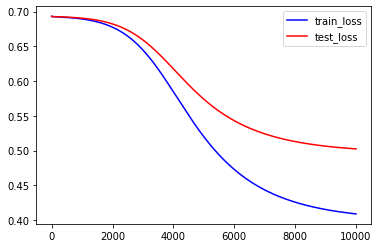

In [11]:
import matplotlib.pyplot as plt
a = [i for i in range(i+1)]
plt.plot(a, train_loss_list,label = 'train_loss', c = 'b')
plt.plot(a, test_loss_list,label = 'test_loss', c = 'r')
plt.legend()
plt.show()

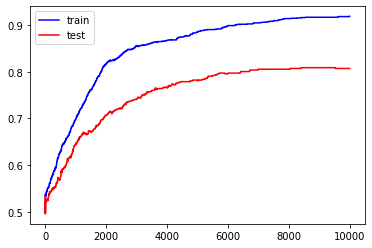

In [12]:
plt.plot(a, train_acc_list,label = 'train', c = 'b')
plt.plot(a, test_acc_list,label = 'test', c = 'r')
plt.legend()
plt.show()

In [13]:
y_train, y_test = t_train, t_test
y_pred_train = network.predict(x_train).round()
y_pred_test = network.predict(x_test).round()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(t_train,y_pred_train))
print(classification_report(t_train,y_pred_train))
print(accuracy_score(t_train, y_pred_train))

print(confusion_matrix(t_test,y_pred_test))
print(classification_report(t_test,y_pred_test))
print(accuracy_score(t_test, y_pred_test))

[[643  56]
 [ 58 644]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       699
           1       0.92      0.92      0.92       702

    accuracy                           0.92      1401
   macro avg       0.92      0.92      0.92      1401
weighted avg       0.92      0.92      0.92      1401

0.9186295503211992
[[242  60]
 [ 56 243]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       302
           1       0.80      0.81      0.81       299

    accuracy                           0.81       601
   macro avg       0.81      0.81      0.81       601
weighted avg       0.81      0.81      0.81       601

0.8069883527454242
